In [1]:
import ROOT, sys
import numpy as np


ROOT.gStyle.SetGridColor(17)
ROOT.gStyle.SetPadGridX(1)
ROOT.gStyle.SetPadGridY(1)

ROOT.gStyle.SetPadRightMargin(0.01)
ROOT.gStyle.SetPadLeftMargin(0.075)
ROOT.gStyle.SetPadBottomMargin(0.12)

ROOT.gStyle.SetOptFit(1)

ROOT.TH1.AddDirectory(0)



fname_in =  "/work/clas12/kenjo/trains/root/eFPimFPip/lvl1_epimpip.nSidis_005*"
fname_out = "/work/clas12/trottan/rhoAnalysis/outb_data/epPipPim.outb.qa.skim_epimpip.nSidis_005*"

#fname = "outbending*root"
#fname = "outbending*root"
rdf = ROOT.RDataFrame("h22",{fname_in,fname_out})



vals = "pe,the,fie,ppip,thpip,fipip,ppim,thpim,fipim,angPimPip,phi_t"
vals += ",angPimPip_LF,angPimPip_CM"
vals += ",Q2,xb,ww,mt"
vals += ",mmpro,misse"
vals += ",mrho,rhoPhi_CM"
vals += ",x0,y0,x1,y1,x01,x4,y4,x5,y5"



rdf = rdf.Define("vals","""
double E0 = 10.6041, Mpro = 0.938272, Mele = 0.000511, Mpi = 0.13957, Mpi0 = 0.1349769;
TLorentzVector beam, targ;
beam.SetXYZM(0,0,E0,Mele);
targ.SetXYZM(0,0,0,Mpro);


TLorentzVector ele, pip, pim;
ele.SetXYZM(ex, ey, ez, Mele);
//pro.SetXYZM(prox, proy, proz, Mpro);
pip.SetXYZM(pipx, pipy, pipz, Mpi);
pim.SetXYZM(pimx, pimy, pimz, Mpi);

double pe = ele.P(), the=ele.Theta()*TMath::RadToDeg(), fie=ele.Phi()*TMath::RadToDeg();
double ppip = pip.P(), thpip=pip.Theta()*TMath::RadToDeg(), fipip=pip.Phi()*TMath::RadToDeg();
double ppim = pim.P(), thpim=pim.Theta()*TMath::RadToDeg(), fipim=pim.Phi()*TMath::RadToDeg();




double mrho = (pip+pim).M();
//double mdelta = (pro+pip).M();

//double mm2pip = (beam+targ-ele-pro-pim).M2();
//double mm2pim = (beam+targ-ele-pro-pip).M2();
double mmpro = (beam+targ-ele-pip-pim).M();
double misse = (beam+targ-ele-pip-pim).E();
//double mepx = (beam+targ-ele-pro).M();


auto q = (beam-ele);
double Q2 = - (beam-ele).M2();
double ww = (beam+targ-ele).M();
double xb = Q2/(ww*ww - targ.M2() + Q2);
double mt = - ((beam+targ-ele-pip-pim)-targ).M2();


double Theta_q = q.Theta();
double Phi_el = ele.Phi();

auto Rot_Matrix = [&](TLorentzVector vector, int Lab2CM_or_CM2Lab, double Theta_Rot, double Phi_Rot){ 

        double Rot_X1 = vector.X();
        double Rot_Y1 = vector.Y();
        double Rot_Z1 = vector.Z();

        double Rot_X = Rot_X1;
        double Rot_Y = Rot_Y1;
        double Rot_Z = Rot_Z1;



        // Lab2CM_or_CM2Lab is a parameter which determines if you rotating from the lab frame to the CM frame, or if you are rotating back in the opposite direction
        // Lab2CM_or_CM2Lab = -1 gives a rotation to the CM frame (from the lab frame)
        // Lab2CM_or_CM2Lab = +1 gives a rotation to the lab frame (from the CM frame)


        Theta_Rot = -1*Theta_Rot;   // Always give the angle of rotation Theta as the value given by .Theta()
                                    // This subroutine will handle the fact that the matrix rotation wants the negative of the angle of rotation


        // Rotation to Lab Frame
        if(Lab2CM_or_CM2Lab == -1){
            Rot_X = Rot_X1*TMath::Cos(Theta_Rot)*TMath::Cos(Phi_Rot) - Rot_Z1*TMath::Sin(Theta_Rot) + Rot_Y1*TMath::Cos(Theta_Rot)*TMath::Sin(Phi_Rot);
            Rot_Y = Rot_Y1*TMath::Cos(Phi_Rot) - Rot_X1*TMath::Sin(Phi_Rot);
            Rot_Z = Rot_Z1*TMath::Cos(Theta_Rot) + Rot_X1*TMath::Cos(Phi_Rot)*TMath::Sin(Theta_Rot) + Rot_Y1*TMath::Sin(Theta_Rot)*TMath::Sin(Phi_Rot);
        }


        // Rotation to CM Frame
        if(Lab2CM_or_CM2Lab == 1){
            Rot_X = Rot_X1*TMath::Cos(Theta_Rot)*TMath::Cos(Phi_Rot) + Rot_Z1*TMath::Cos(Phi_Rot)*TMath::Sin(Theta_Rot) - Rot_Y1*TMath::Sin(Phi_Rot);
            Rot_Y = Rot_Y1*TMath::Cos(Phi_Rot) + Rot_X1*TMath::Sin(Phi_Rot)*TMath::Cos(Theta_Rot) + Rot_Z1*TMath::Sin(Theta_Rot)*TMath::Sin(Phi_Rot);
            Rot_Z = Rot_Z1*TMath::Cos(Theta_Rot) - Rot_X1*TMath::Sin(Theta_Rot);
        }



        TLorentzVector vector_Rotated(Rot_X, Rot_Y, Rot_Z, vector.E());

        return vector_Rotated;


    };


auto angPimPip_LF = pim.Vect().Angle(pip.Vect())*TMath::RadToDeg();

auto rho = pip+pim;


// Center of Mass Frame
auto beam_Clone = Rot_Matrix(beam, -1, Theta_q, Phi_el);
auto targ_Clone = Rot_Matrix(targ, -1, Theta_q, Phi_el);
auto ele_Clone  = Rot_Matrix(ele,  -1, Theta_q, Phi_el);
auto pip_Clone = Rot_Matrix(pip,  -1, Theta_q, Phi_el);
auto pim_Clone = Rot_Matrix(pim,  -1, Theta_q, Phi_el);
auto q_Clone = Rot_Matrix(q,  -1, Theta_q, Phi_el);
auto rho_Clone = Rot_Matrix(rho,  -1, Theta_q, Phi_el);






auto fCM = q_Clone + targ_Clone;
auto boost = -(fCM.BoostVector());


auto qlv_Boost(q_Clone);
auto ele_Boost(ele_Clone);
auto beamBoost(beam_Clone);
auto targBoost(targ_Clone);
auto pipBoost(pip_Clone);
auto pimBoost(pim_Clone);
auto rhoBoost(rho_Clone);




qlv_Boost.Boost(boost);
ele_Boost.Boost(boost);
beamBoost.Boost(boost);
targBoost.Boost(boost);
pipBoost.Boost(boost);
pimBoost.Boost(boost);
rhoBoost.Boost(boost);





auto rhoPhi_CM = rhoBoost.Vect().Phi()*TMath::RadToDeg();



auto angPimPip_CM = pimBoost.Vect().Angle(pipBoost.Vect())*TMath::RadToDeg();




TVector3 v0, v1;
v0 = qlv_Boost.Vect().Cross(ele_Boost.Vect());
v1 = qlv_Boost.Vect().Cross(pipBoost.Vect()+pimBoost.Vect());
Double_t c0, c1, c2, c3;
c0 = v0.Dot(pipBoost.Vect()+pimBoost.Vect());
c1 = v0.Dot(v1);
c2 = v0.Mag();
c3 = v1.Mag();


double phi_t = (c0/TMath::Abs(c0)) * TMath::ACos(c1 /(c2*c3))*TMath::RadToDeg();
if(phi_t <= 0){
    phi_t = phi_t +360;
}








// Rho Frame
auto Phi_rho =  rhoBoost.Phi();
auto Theta_rho = rhoBoost.Theta();

TLorentzVector rhoBoost_r;
rhoBoost_r.SetXYZM(rhoBoost.Vect().x(), rhoBoost.Vect().y(), rhoBoost.Vect().z(), 0.7754);

auto pip_Clone2 = Rot_Matrix(pipBoost,  -1, Theta_rho, Phi_rho);
auto pim_Clone2 = Rot_Matrix(pimBoost,  -1, Theta_rho, Phi_rho);
auto rho_Clone2 = Rot_Matrix(rhoBoost_r,  -1, Theta_rho, Phi_rho);


auto fCM2 = -rho_Clone2;
auto boost2 = -(fCM2.BoostVector());

auto pipBoost2(pip_Clone2);
auto pimBoost2(pim_Clone2);

pipBoost2.Boost(boost2);
pimBoost2.Boost(boost2);
auto angPimPip = pimBoost2.Vect().Angle(pipBoost2.Vect())*TMath::RadToDeg();

double x0=0.15, y0=2.63;
double x1=0.45, y1=4.5;
double x01 = 0.34;
double x4=0.45, y4=4.8;
double x5=0.666, y5=6.2;

//ihel = static_cast<Int_t> (ihel);
//ihel = static_cast<Float_t> (ihel);

ihel = 1.00*ihel;

return vector<double> {"""+vals+"};")



phcuts = "angEPim>10 && angEPip>10"

for iv, vname in enumerate(vals.split(',')):
    rdf = rdf.Define(vname, "vals[{}]".format(iv))
    
    
    
    

    

    
    


    
    
rdf = rdf.Filter("Q2>0.8 && ww>1.8")
    





Welcome to JupyROOT 6.22/06


In [2]:
rdf.Display("ihel",5).Print()


rdf.Display()
#fname_in =  "/work/clas12/kenjo/trains/root/eFPimFPip/lvl1_epimpip.nSidis_005*"
#fname_out = "/work/clas12/trottan/rhoAnalysis/outb_data/epPipPim.outb.qa.skim_epimpip.nSidis_005*"
#rdf = ROOT.RDataFrame("h22",{fname_in,fname_out})
print(rdf.Count().GetValue())


#rdf_in = ROOT.RDataFrame("h22",{fname_in})
#print(rdf_in.Count().GetValue())

#rdf_out = ROOT.RDataFrame("h22",{fname_out})
#print(rdf_out.Count().GetValue())


#name = rdf.GetColumnNames()
#for i in name:
#    print(i)


24166959
ihel | 
-1   | 
-1   | 
-1   | 
-1   | 
-1   | 


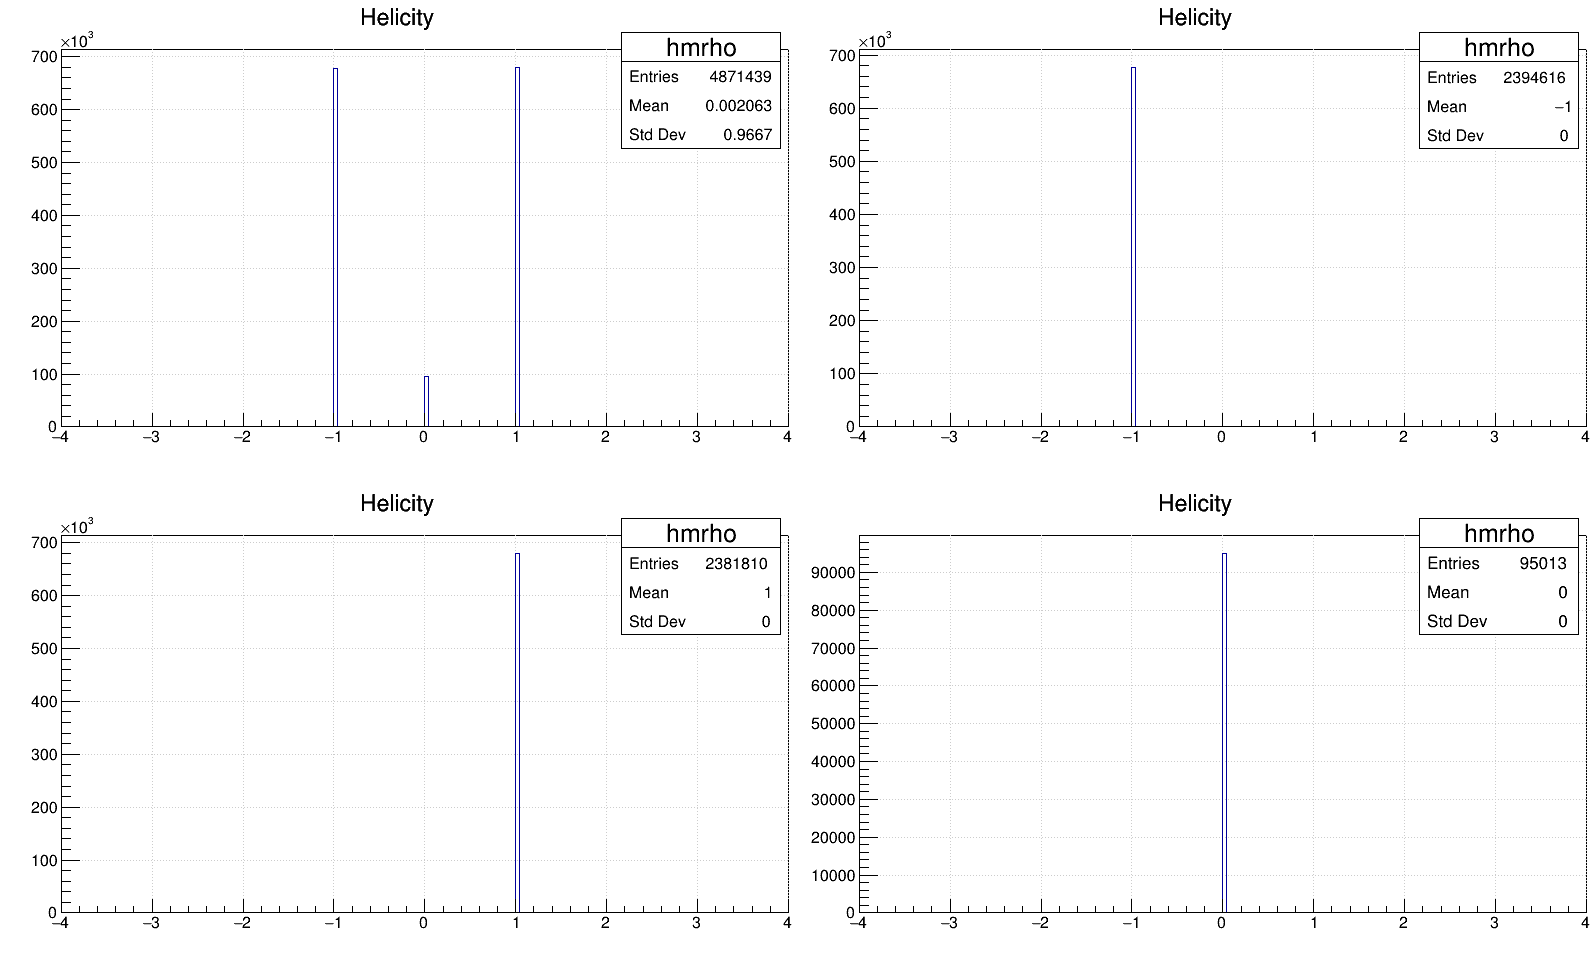

In [2]:
#cut2 = rdf.Filter("misse < 2")
cut3 = rdf.Filter("mmpro < 1.15 && mmpro > 0.85")
#cut3 = cut2.Filter("mt < 1")
#cut3 = cut2.Filter("mrho > 0.65 && mrho < 0.9")
#cut3 = cut2.Filter("mt < 1.5")


hheli =cut3.Histo1D(("hmrho","Helicity",200,-4,4), "ihel")

hheli_neg =cut3.Filter("ihel <0").Histo1D(("hmrho","Helicity",200,-4,4), "ihel")
hheli_pos =cut3.Filter("ihel >0").Histo1D(("hmrho","Helicity",200,-4,4), "ihel")
hheli_zero =cut3.Filter("ihel == 0").Histo1D(("hmrho","Helicity",200,-4,4), "ihel")

c1 = ROOT.TCanvas("c1","c1", 1600,1000)
c1.Divide(2,2,.001,0.001)
c1.Draw()
c1.cd(1)
hheli.Draw()
c1.cd(2)
hheli_neg.Draw()
c1.cd(3)
hheli_pos.Draw()

c1.cd(4)
hheli_zero.Draw()

Hi


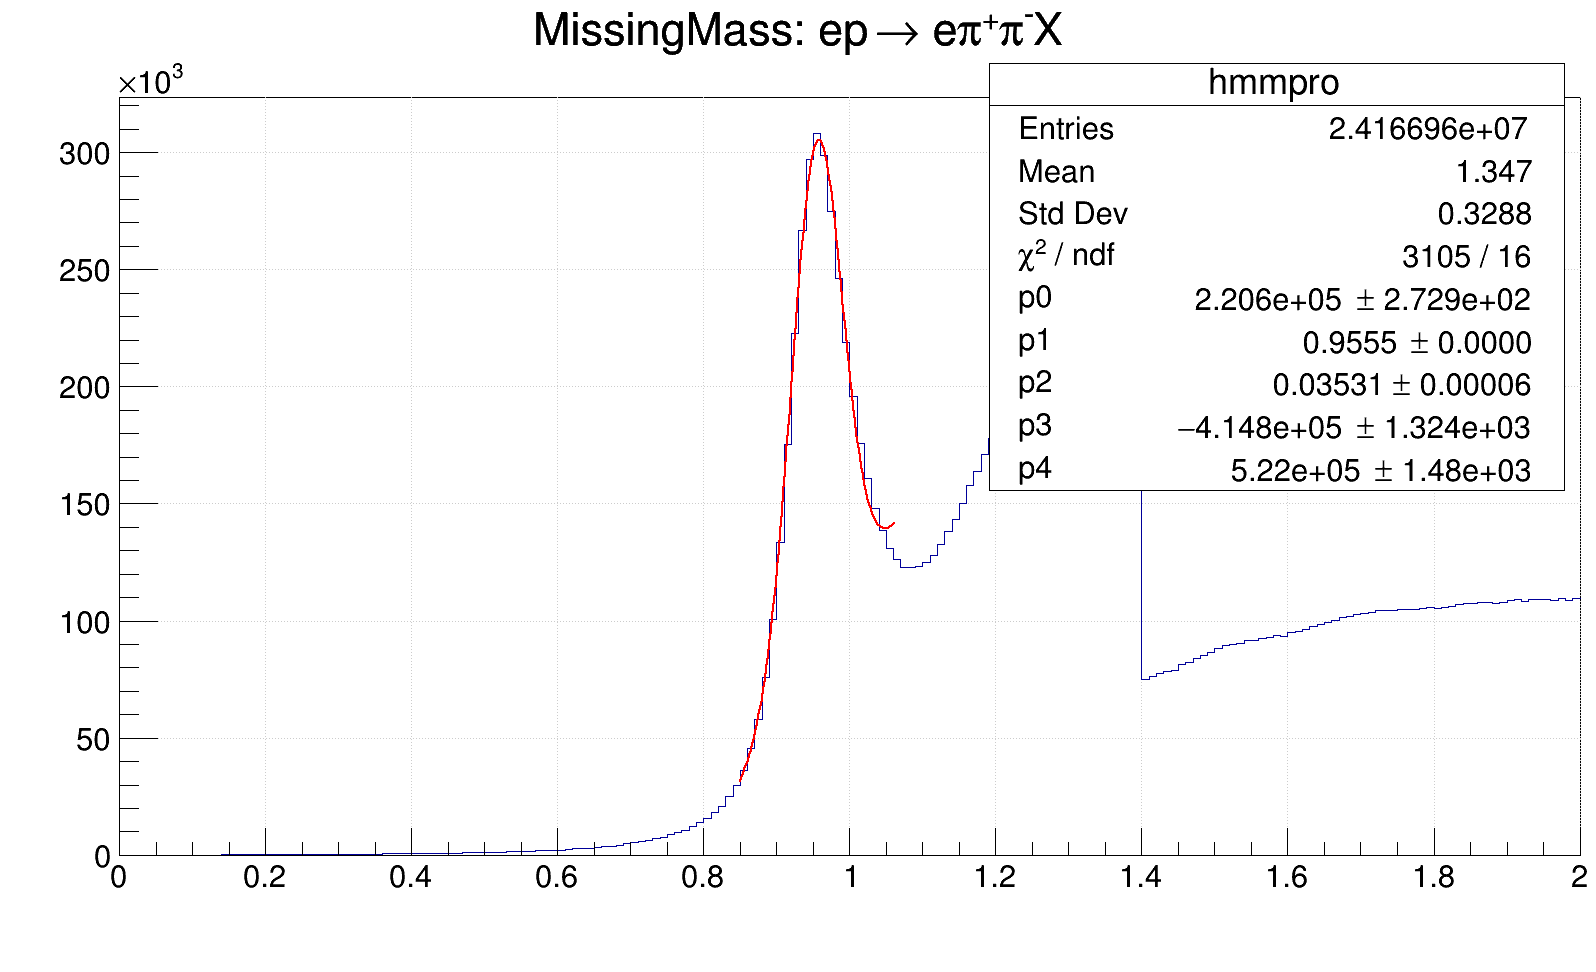

In [35]:


#hmm2pip = rdf.Histo1D(("hmm2pip","MissingMass^{2}: ep#rightarrow ep#pi^{-}X",200,-1,1), "mm2pip")
#hmm2pim = rdf.Histo1D(("hmm2pim","MissingMass^{2}: ep#rightarrow ep#pi^{+}X",200,-1,1), "mm2pim")
hmmpro = rdf.Histo1D(("hmmpro","MissingMass: ep#rightarrow e#pi^{+}#pi^{-}X",200,0,2), "mmpro")


def fit1d(h1):
    mx = h1.GetBinCenter(h1.GetMaximumBin())
    fy = ROOT.TF1("fy","gaus(0)+pol1(3)",mx-0.1,mx+0.1)
    fy.SetParameters(1,0.9387,0.014,1)
    fy.SetParLimits(0,0,1e7)
    fy.SetParLimits(1,0.9387-0.05,0.9387+0.05)
    #fy.SetParLimits(2,0.005,0.02)
    h1.Fit(fy,"QR")
    mu,sig = fy.GetParameter(1),fy.GetParameter(2)
    fy.SetRange(mu-3*sig, mu+3*sig)
    h1.Fit(fy,"QR")
    print("Hi")

fit1d(hmmpro)

c1 = ROOT.TCanvas("c1","c1", 1600,1000)
#c1.Divide(2,2,.001,0.001)
c1.Draw()
#c1.cd(1)
hmmpro.Draw()
#c1.cd(2)
#hmisse.Draw()

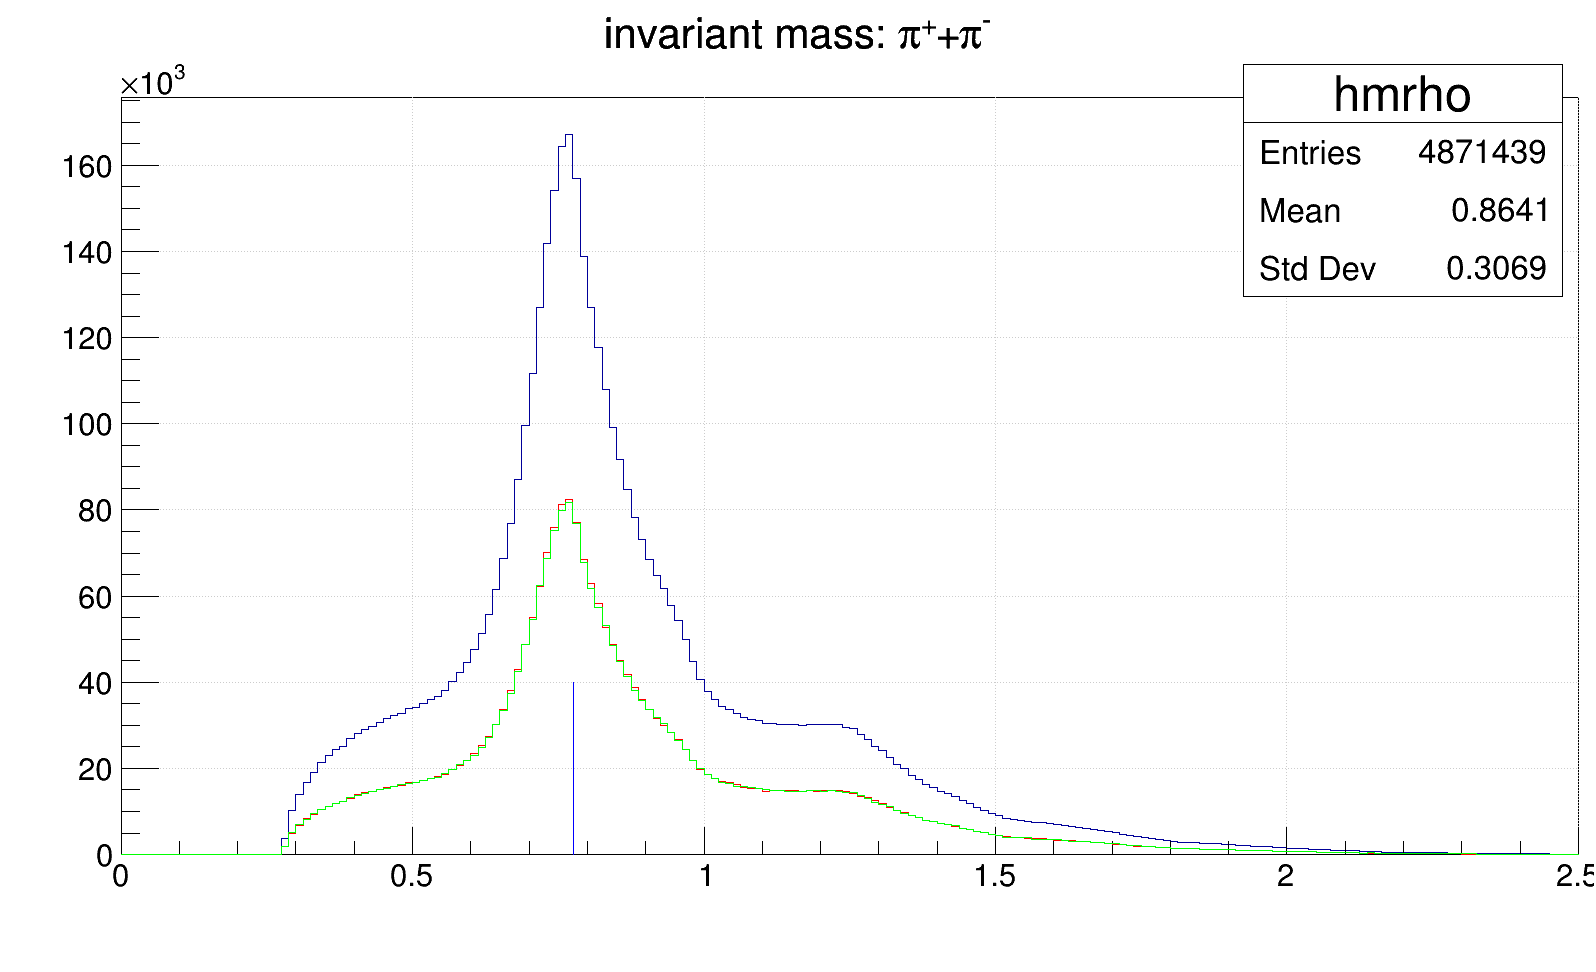

In [2]:
cut2 = rdf.Filter("mmpro < 1.2 && mmpro > 0.85")


line =  ROOT.TLine(0.7754, 0, 0.7754,40000)
hmrho = cut2.Histo1D(("hmrho","invariant mass: #pi^{+}+#pi^{-}",200,0,2.5), "mrho")
hmrho_neg = cut2.Filter("ihel <0").Histo1D(("hmrho","invariant mass: #pi^{+}+#pi^{-}",200,0,2.5), "mrho")
hmrho_pos = cut2.Filter("ihel >0").Histo1D(("hmrho","invariant mass: #pi^{+}+#pi^{-}",200,0,2.5), "mrho")



c1 = ROOT.TCanvas("c1","c1", 1600,1000)
c1.Divide(1,1,.001,0.001)
c1.Draw()
c1.cd(1)
hmrho.Draw()
line.SetLineColor(4)
line.Draw()

hmrho_neg.SetLineColor(2)
hmrho_neg.Draw("same")

hmrho_pos.SetLineColor(3)
hmrho_pos.Draw("same")

In [2]:
import numpy as np
ipar1 = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12], dtype=np.int32) 
ipar2 = np.array([13,1,2,14,4,5,6,7,8,15,16,11,12],dtype=np.int32)

#ipart = np.array([[0,1,2,3,4,5,6,7,8,9,10,11,12],[13,1,2,14,4,5,6,7,8,15,16,11,12]], dtype=np.int32) 



par_Num = []
for i in range(0,2*(135)):
    if i == 0:
        n = [0,1,2,3,4,5,6,7,8,9,10,11,12]
    else:
        j = 13 + (i-1)*4
        n = [j,1,2,j+1,4,5,6,7,8,j+2,j+3,11,12]
    #print(n)
    par_Num.append(n)
print((par_Num))
ipart = np.array(par_Num, dtype=np.int32) 


#Custum class that makes a chi2 for both fits

class GlobalChi2(object):
    def __init__(self, f1,numOfHist):
        self._f1 = f1
        #self._f2 = f2
        self._numOfHist = numOfHist
    def __call__(self, par):
        # parameter vector is first background (in common 1 and 2) and then is
        # signal (only in 2)
 
        # the zero-copy way to get a numpy array from a double *
        par_arr = np.frombuffer(par, dtype=np.float64, count=self._numOfHist*len(ipar1))
 

        
        #p1 = par_arr[ipar1]
        #p2 = par_arr[ipar2]
        #p = [p1,p2]
        
        p = []
        for i in range(0,self._numOfHist):
            #print(par_arr[i])
            p.append(par_arr[ipart[i]])
        
        
        tot = 0
        #for i in self._f1:
        #    tot += i(p1)
        for i in range(0,(self._numOfHist)):
            tot += self._f1[i](p[i])

        
        return tot
ROOT.gInterpreter.Declare("""
    ROOT::Math::Functor foo(const std::function<double(double const *)> &x, int num) { return ROOT::Math::Functor(x,num); }
    //ROOT::Math::Functor foo(GlobalChi2 x, int num) { return ROOT::Math::Functor(x,num); }
    
    """)


def fit1d(h):
   # 3 pieces to the over all fit
    fyp = []
    for i in range(0,len(h)):
        fyp.append(ROOT.TF1("fy","breitwigner(0)+breitwigner(3)+(x-2*0.1396)^[9]*exp(pol2(6))+breitwigner(10)",0.28,2.5))
        
        
    fy1p = []
    for i in range(0,len(h)):
        fy1p.append(ROOT.TF1("fy1","breitwigner(0)",0.28,2.5))
        
    fy2p = []
    for i in range(0,len(h)):
        fy2p.append(ROOT.TF1("fy2","breitwigner(0)",0.28,2.5))
        
    fy3p = []
    for i in range(0,len(h)):
        fy3p.append(ROOT.TF1("fy3","(x-2*0.1396)^[3]*exp(pol2(0))",0.28,2.5))
        
    fy4p = []
    for i in range(0,len(h)):
        fy4p.append(ROOT.TF1("fy4","breitwigner(0)",0.28,2.5))
        
        
    for i in fyp:
        i.SetParName(0,"#rhoAmp")
        i.SetParName(1,"#rho Mean")
        i.SetParName(2,"#rho Sigma")

        i.SetParName(3,"f2 Amp")
        i.SetParName(4,"f2 Mean")
        i.SetParName(5,"f2 Sigma")

        i.SetParName(6,"bg 0")
        i.SetParName(7,"bg 1")
        i.SetParName(8,"bg 2")
        i.SetParName(9,"bg n")
    
        i.SetParName(10,"f0 Amp")
        i.SetParName(11,"f0 Mean")
        i.SetParName(12,"f0 Sigma")
        
    
    opt = ROOT.Fit.DataOptions()
    rang = ROOT.Fit.DataRange()
   
    rang.SetRange(0.28,2.5)
    data = [None]*len(h)
    chi2 = []
    
    
    hp = []
    for i in range(0,len(h)):
        hp.append(ROOT.TH1D())
        
        hp[i] = h[i].GetPtr()
         
        wfy1 = ROOT.Math.WrappedMultiTF1(fyp[i], 1)
        data[i] = ROOT.Fit.BinData(opt,rang)
        ROOT.Fit.FillData(data[i],hp[i])
        
        chi2.append(ROOT.Fit.Chi2Function(data[i],wfy1))
       
    
    
    print("dog",chi2[0],chi2[0].NDim())
    
    
    #Making global Chi2 in custum class
    globalChi2 = GlobalChi2(chi2,len(h))
    
    
    
    
    fitter = ROOT.Fit.Fitter()
    
    Npar = 13 + len(h)*4
    
    parTemp = [200,0.77549,0.1478,10,1.275,0.1867,1,0.05,-0.05,0.5,10,0.980,0.05,200,10,0.5,10]
    for  i in range(1,len(h)):
        parTemp.append(200)
        parTemp.append(10)
        parTemp.append(0.5)
        parTemp.append(10)
        
    print("Partemp len", len(parTemp), "Npar", Npar) 
    par0 = np.array(parTemp)
        

    
    fitter.Config().SetParamsSettings(Npar, par0)
    #fyp.FixParameter(4,1.275)
    #fyp.FixParameter(5,0.1867)
    #fitter.Config().ParSettings(4).Fix()
    fitter.Config().ParSettings(4).SetLimits(1,1.275)
    
    fitter.Config().ParSettings(5).SetLimits(0,0.1867)

     #fy.FixParameter(12,0.09)
    #fyp.SetParLimits(12,0.04,0.09)
    fitter.Config().ParSettings(12).SetLimits(0.04,0.09)
    
    #fyp.SetParLimits(2,0,1e7)
    #fitter.Config().ParSettings(2).Fix()
    fitter.Config().ParSettings(2).SetLimits(0,0.1478)

    #fyp.SetParLimits(3,0,1e7)
    fitter.Config().ParSettings(3).SetLimits(0,1e7)
        
    
    
    #fyp.SetParLimits(10,0,1e7)
    fitter.Config().ParSettings(10).SetLimits(0,1e7)
        
        
    #fyp.SetParLimits(11,0.8,1)
    fitter.Config().ParSettings(11).SetLimits(0.8,1)
    
    fitter.Config().ParSettings(0).SetLimits(0,1e7)
    
    
    for i in range(1,len(h)):
        j = 13 + (i-1)*4
        #print(j,j+1,j+2,j+3)
        fitter.Config().ParSettings(j).SetLimits(0,1e7)
        fitter.Config().ParSettings(j+1).SetLimits(0,1e7)
        fitter.Config().ParSettings(j+2).SetLimits(0,1)
        fitter.Config().ParSettings(j+3).SetLimits(0,1e7)
        
    
    #Minimizing chi2 fits
    fitter.Config().MinimizerOptions().SetPrintLevel(0)
    fitter.Config().SetMinimizer("Minuit2", "Migrad")
    
    
    #in order to fit global Chi2 function it needs to be in a wrapper
    #Functor fails in pyroot for root version 6.24 or less
    #globalChi2Functor = ROOT.Math.Functor(globalChi2, Npar) Faster way of doing it for v6.26 and up 
    
    
    #calls ROOT functor in ROOT
    globalChi2Functor = ROOT.foo(globalChi2,Npar)
    
    print("functor ",globalChi2Functor.NDim())
    
    #making fit for our Global Chi2 function
    dataSum = 0
    for i in data:
        dataSum += i.Size()
    print(dataSum)

    fitter.FitFCN(globalChi2Functor, 0,int(dataSum), True)
    
 
    
    
    result = fitter.Result()
    parsN = result.GetParams()
    parsNError = result.GetErrors()
    
    print("parsN ", parsN[0],parsN[13],parsN[17])
    print("parsNError ", parsNError[0],parsNError[13],parsNError[17])
    
    for i in range(0,len(h)):
        fyp[i].SetFitResult(result, ipart[i])
        fyp[i].SetRange(rang().first, rang().second)
        
    
    rhoAmp = [parsN[0]]
    for i in range(1,len(h)):
        j = 13 + (i-1)*4
        rhoAmp.append(parsN[j])
        
    rhoAmpError = [parsNError[0]]
    for i in range(1,len(h)):
        j = 13 + (i-1)*4
        rhoAmpError.append(parsNError[j])
        
        
    for i in range(0,len(h)):
        if i == 0:
            fy1p[i].FixParameter(0,parsN[0])
            fy1p[i].FixParameter(1,parsN[1])
            fy1p[i].FixParameter(2,parsN[2])
        else:
            j = 13 + (i-1)*4
            fy1p[i].FixParameter(0,parsN[j])
            fy1p[i].FixParameter(1,parsN[1])
            fy1p[i].FixParameter(2,parsN[2])
        fy1p[i].SetLineColor(ROOT.kBlack)
        
        
    for i in range(0,len(h)):
        if i == 0:
            fy2p[i].FixParameter(0,parsN[3])
            fy2p[i].FixParameter(1,parsN[4])
            fy2p[i].FixParameter(2,parsN[5])
        else:
            j = 13 + (i-1)*4 +1
            fy2p[i].FixParameter(0,parsN[j])
            fy2p[i].FixParameter(1,parsN[4])
            fy2p[i].FixParameter(2,parsN[5])
        fy2p[i].SetLineColor(ROOT.kGreen)
        
        
    for i in range(0,len(h)):
        if i == 0:
            fy3p[i].FixParameter(0,parsN[6])
            fy3p[i].FixParameter(1,parsN[7])
            fy3p[i].FixParameter(2,parsN[8])
            fy3p[i].FixParameter(3,parsN[9])
        else:
            j = 13 + (i-1)*4 +2
            fy3p[i].FixParameter(0,parsN[6])
            fy3p[i].FixParameter(1,parsN[7])
            fy3p[i].FixParameter(2,parsN[8])
            fy3p[i].FixParameter(3,parsN[j])
        fy3p[i].SetLineColor(ROOT.kBlue)
        
    for i in range(0,len(h)):
        if i == 0:
            fy4p[i].FixParameter(0,parsN[10])
            fy4p[i].FixParameter(1,parsN[11])
            fy4p[i].FixParameter(2,parsN[12])
        else:
            j = 13 + (i-1)*4 +3
            fy4p[i].FixParameter(0,parsN[j])
            fy4p[i].FixParameter(1,parsN[11])
            fy4p[i].FixParameter(2,parsN[12])
        fy4p[i].SetLineColor(ROOT.kPink)

    for i in range(0,len(h)):
        hp[i].GetListOfFunctions().Add(fyp[i])
        hp[i].GetListOfFunctions().Add(fy1p[i])
        hp[i].GetListOfFunctions().Add(fy2p[i])
        hp[i].GetListOfFunctions().Add(fy3p[i])
        hp[i].GetListOfFunctions().Add(fy4p[i])
    print(len(hp),hp)
    return hp,rhoAmp, rhoAmpError

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], [13, 1, 2, 14, 4, 5, 6, 7, 8, 15, 16, 11, 12], [17, 1, 2, 18, 4, 5, 6, 7, 8, 19, 20, 11, 12], [21, 1, 2, 22, 4, 5, 6, 7, 8, 23, 24, 11, 12], [25, 1, 2, 26, 4, 5, 6, 7, 8, 27, 28, 11, 12], [29, 1, 2, 30, 4, 5, 6, 7, 8, 31, 32, 11, 12], [33, 1, 2, 34, 4, 5, 6, 7, 8, 35, 36, 11, 12], [37, 1, 2, 38, 4, 5, 6, 7, 8, 39, 40, 11, 12], [41, 1, 2, 42, 4, 5, 6, 7, 8, 43, 44, 11, 12], [45, 1, 2, 46, 4, 5, 6, 7, 8, 47, 48, 11, 12], [49, 1, 2, 50, 4, 5, 6, 7, 8, 51, 52, 11, 12], [53, 1, 2, 54, 4, 5, 6, 7, 8, 55, 56, 11, 12], [57, 1, 2, 58, 4, 5, 6, 7, 8, 59, 60, 11, 12], [61, 1, 2, 62, 4, 5, 6, 7, 8, 63, 64, 11, 12], [65, 1, 2, 66, 4, 5, 6, 7, 8, 67, 68, 11, 12], [69, 1, 2, 70, 4, 5, 6, 7, 8, 71, 72, 11, 12], [73, 1, 2, 74, 4, 5, 6, 7, 8, 75, 76, 11, 12], [77, 1, 2, 78, 4, 5, 6, 7, 8, 79, 80, 11, 12], [81, 1, 2, 82, 4, 5, 6, 7, 8, 83, 84, 11, 12], [85, 1, 2, 86, 4, 5, 6, 7, 8, 87, 88, 11, 12], [89, 1, 2, 90, 4, 5, 6, 7, 8, 91, 92, 11, 12], [93, 1, 2, 94, 

In [3]:
import numpy as np


nbins = 9# //number of bins for BSA

binSize = 360/nbins# //Size of each bin using Phi* (times 2 for Positive and negtive)

#hphistar = rdf.Histo1D(("hphistar","Trento #phi;Trento #phi",200,-200,200), "phi_t")
#cut2 = rdf.Filter("misse < 2")
cut2 = rdf.Filter("mmpro < 1.2 && mmpro > 0.85")
#cut2 = cut2.Filter("mt < 1")
#cut2 = cut2.Filter("mrho > 0.65 && mrho < 0.9")




cdNumber = 1
Np1 = np.zeros(nbins)
Nm1 = np.zeros(nbins)

q2Cuts = ["xb<x1 && Q2>2 && Q2<(y0 + (xb-x0)/(x1-x0)*(y1-y0)) && xb<x01","xb<x1 && Q2>2 && Q2<(y0 + (xb-x0)/(x1-x0)*(y1-y0)) && xb>x01","xb<x1 && Q2>2","xb>x1 && Q2>2 && Q2< (y4 + (xb-x4)/(x5-x4)*(y5-y4))","xb>x1 && Q2>2"]    

tLimits = [np.linspace(0.42,0.9,num=4),np.linspace(0.42,0.9,num=4),np.linspace(0.46,0.9,4),np.linspace(0.62,0.98,4),np.linspace(0.82,1.26,4)] 

tCuts = []
for i in tLimits:
    #print("-t > " + str(i[0]) + "  && -t < "+ str(i[1]))
    #print("-t > " + str(i[1]) + "  && -t < "+ str(i[2]))
    tCuts.append("mt > " + str(i[0]) + "  && mt < "+ str(i[1]))
    tCuts.append("mt > " + str(i[1]) + "  && mt < "+ str(i[2]))
    tCuts.append("mt > " + str(i[2]) + "  && mt < "+ str(i[3]))
    

phiBins = []


tCount = 0
#c1.Print(pdfname+"[")
for k in q2Cuts:
    print(k)
    for j in range(tCount,len(tCuts)):
        print(tCuts[j])
        new = cut2.Filter(k).Filter(tCuts[j])
        for i in range(0,360,int(binSize)):
            temp = int((i+binSize)/binSize - 1)
            printTemp = "phi_t > " + str(i) + " && phi_t < " + str(i+ binSize)
            #print(printTemp)
            c2 = new.Filter(printTemp)
            phiBins.append(c2)
        tCount += 1
        if tCount % 3 ==0:
            break
    

xb<x1 && Q2>2 && Q2<(y0 + (xb-x0)/(x1-x0)*(y1-y0)) && xb<x01
mt > 0.42  && mt < 0.58
mt > 0.58  && mt < 0.74
mt > 0.74  && mt < 0.9
xb<x1 && Q2>2 && Q2<(y0 + (xb-x0)/(x1-x0)*(y1-y0)) && xb>x01
mt > 0.42  && mt < 0.58
mt > 0.58  && mt < 0.74
mt > 0.74  && mt < 0.9
xb<x1 && Q2>2
mt > 0.46  && mt < 0.6066666666666667
mt > 0.6066666666666667  && mt < 0.7533333333333334
mt > 0.7533333333333334  && mt < 0.9
xb>x1 && Q2>2 && Q2< (y4 + (xb-x4)/(x5-x4)*(y5-y4))
mt > 0.62  && mt < 0.74
mt > 0.74  && mt < 0.86
mt > 0.86  && mt < 0.98
xb>x1 && Q2>2
mt > 0.82  && mt < 0.9666666666666667
mt > 0.9666666666666667  && mt < 1.1133333333333333
mt > 1.1133333333333333  && mt < 1.26


In [4]:

h_p = [] 

tCount = 1
QCount = 1
phiCount = 0
for i in phiBins:
    if not (QCount == 1 and (tCount == 2 or tCount == 3) and (phiCount == 0 or phiCount == 8)):
        h_p.append(i.Filter("ihel > 0").Histo1D(("hmrho","IM:#pi^{+}+#pi^{-},Heli+, Qbin:" + str(QCount) + "tBin" + str(tCount) + "phibin:" + str(phiCount),200,0,2.5), "mrho"))
    #print(str(tCount) + "phibin:" + str(phiCount))
    phiCount +=1 
    if phiCount % 9 ==0:
        phiCount = 0
        tCount += 1
    if tCount == 4:
        tCount = 1
        QCount +=1

#hp,rhoAmp_p, rhoAmpError_p = fit1d(h_p)



h_m = [] 

QCount = 1
tCount = 1
phiCount = 0
for i in phiBins:
    if not (QCount == 1 and (tCount == 2 or tCount == 3) and (phiCount == 0 or phiCount == 8)):
        h_m.append(i.Filter("ihel < 0").Histo1D(("hmrho","IM:#pi^{+}+#pi^{-},Heli- Qbin:" + str(QCount) + "tBin" + str(tCount) + "phibin:" + str(phiCount),200,0,2.5), "mrho"))
    phiCount +=1 
    if phiCount % 9 ==0:
        phiCount = 0
        tCount += 1
    if tCount == 4:
        tCount = 1
        QCount +=1

#hm,rhoAmp_m, rhoAmpError_m = fit1d(h_m)

print("len is",len(h_p),len(h_m))

h = h_p + h_m


hc,rhoAmp, rhoAmpError = fit1d(h)

#print(rhoAmp)
#print()
#print(rhoAmpError)


rhoAmp_p,rhoAmp_m = np.split(np.array(rhoAmp),2)
rhoAmpError_p,rhoAmpError_m = np.split(np.array(rhoAmpError),2)

print(repr(rhoAmp_p))
print(repr(rhoAmp_m))
print()
print(repr(rhoAmpError_p))
print(repr(rhoAmpError_m))


len is 131 131
dog <cppyy.gbl.ROOT.Fit.Chi2FCN<ROOT::Math::IBaseFunctionMultiDimTempl<double>,ROOT::Math::IParametricFunctionMultiDimTempl<double> > object at 0x55ffe4eb0600> 13
Partemp len 1061 Npar 1061
functor  1061
28399
parsN  29.999675820735483 50.12714616503544 83.26021383620042
parsNError  0.37223694460131185 0.4813059137354081 0.7663947321212561
262 [<cppyy.gbl.TH1D object at 0x55ffe37a27f0>, <cppyy.gbl.TH1D object at 0x55ffe5f00ee0>, <cppyy.gbl.TH1D object at 0x55ffe5e6b550>, <cppyy.gbl.TH1D object at 0x55ffde2da9f0>, <cppyy.gbl.TH1D object at 0x55ffde24da90>, <cppyy.gbl.TH1D object at 0x55ffde2af220>, <cppyy.gbl.TH1D object at 0x55ffe62eff40>, <cppyy.gbl.TH1D object at 0x55ffe61b84a0>, <cppyy.gbl.TH1D object at 0x55ffe61a6620>, <cppyy.gbl.TH1D object at 0x55ffe61a73d0>, <cppyy.gbl.TH1D object at 0x55ffe630db10>, <cppyy.gbl.TH1D object at 0x55ffe616c810>, <cppyy.gbl.TH1D object at 0x55ffe610c170>, <cppyy.gbl.TH1D object at 0x55ffe61a1000>, <cppyy.gbl.TH1D object at 0x55ffe3cd

In [5]:
canvas = ROOT.TCanvas("canvas")
pdf_file = ROOT.TPDF("Q2xB_IMplotsCombine.pdf", 0)


canvas.SaveAs(pdf_file.GetName()+"[")
#for i in h:
#    i.Draw()
#    canvas.SaveAs(pdf_file.GetName()+"")


for i in range(0,len(h)):
    h[i].Draw()
    canvas.SaveAs(pdf_file.GetName()+"")


canvas.SaveAs(pdf_file.GetName()+"]")

pdf_file.Close()

Error in <TPDF::Open>: Invalid page orientation 0


dog <cppyy.gbl.ROOT.Fit.Chi2FCN<ROOT::Math::IBaseFunctionMultiDimTempl<double>,ROOT::Math::IParametricFunctionMultiDimTempl<double> > object at 0x558182b9e350> 13
Partemp len 45 Npar 45
functor  45
1209
parsN  24.384029931323603 42.82470055017029 73.99127035068176
parsNError  0.8406293355855965 1.1371427155459912 1.5224986832373943
8 [<cppyy.gbl.TH1D object at 0x55817ad62a30>, <cppyy.gbl.TH1D object at 0x55817a172e50>, <cppyy.gbl.TH1D object at 0x558174afc9f0>, <cppyy.gbl.TH1D object at 0x558179fc3550>, <cppyy.gbl.TH1D object at 0x558174a6fa90>, <cppyy.gbl.TH1D object at 0x558174ad1220>, <cppyy.gbl.TH1D object at 0x55817caaacb0>, <cppyy.gbl.TH1D object at 0x55817c937640>]


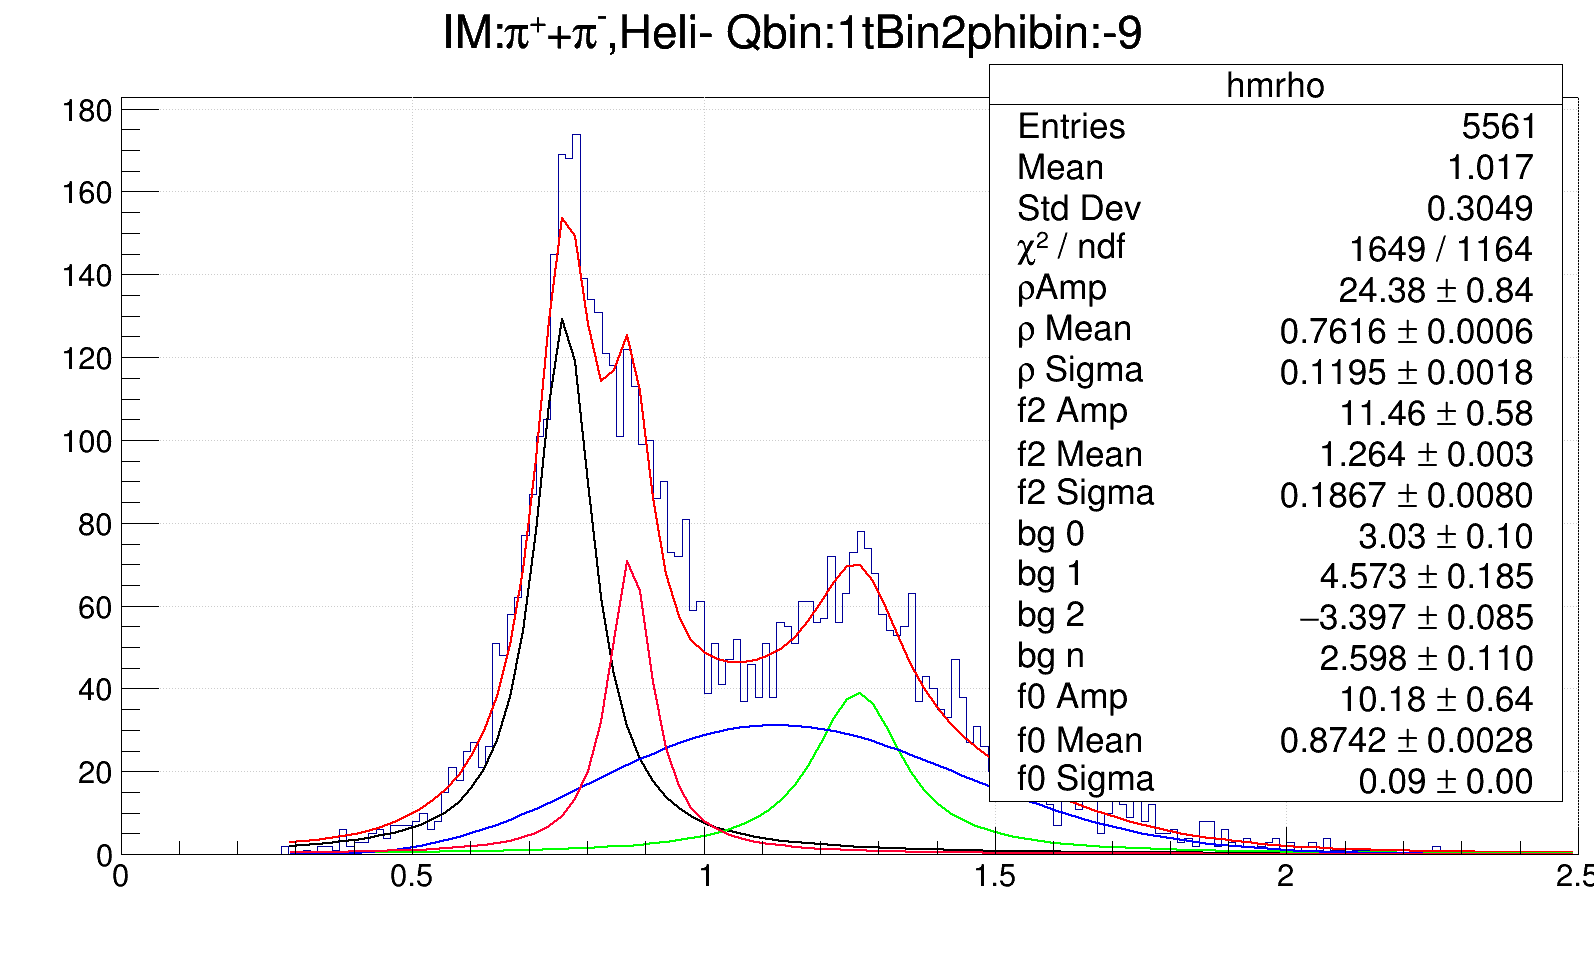

In [4]:
hist = []
for i in range(0,8):
    hist.append(phiBins[i].Filter("ihel > 0").Histo1D(("hmrho","IM:#pi^{+}+#pi^{-},Heli- Qbin:" + str(1) + "tBin" + str(2) + "phibin:" + str(i-9),200,0,2.5), "mrho"))


fit1d(hist)
c1 = ROOT.TCanvas("c1","c1", 1600,1000)
c1.Divide(1,1,.001,0.001)
c1.Draw()
c1.cd(1)
hist[0].Draw()
#c1.cd(2)
#hist[8].Draw()

In [28]:

rhoAmp_p = np.array([ 38.746136  ,  68.70939838, 112.78715143, 156.47837848,
       181.50393081, 136.13453316,  84.71538868,  55.44028468,
        26.09914835,  29.88112273,  54.74711357,  85.63841392,
       101.34910844,  70.33316885,  43.6672681 ,  26.50927241,
        54.80905279,  61.973867  ,  69.99389264,  75.38223013,
        73.68880659,  67.32877452,  54.52441242,  51.18786197,
        49.44123399,  47.36570258,  53.69928088,  62.15076815,
        69.67819813,  69.08633175,  62.74007325,  50.70575754,
        46.82851981,  41.2868866 ,  91.29289976, 133.04021413,
       188.2367488 , 237.23187302, 266.13765014, 212.14850698,
       143.05613031, 108.86219154,  81.87943276,  57.98444507,
        86.87301197, 122.2955718 , 165.28186859, 185.28921847,
       143.79843478,  99.76463986,  76.94574336,  51.1943284 ,
         7.15276637,   8.30703362,   8.91887026,  10.16552948,
         9.98912322,   8.8950898 ,   6.93626314,   7.82778273,
         7.80065989,  10.24594182,  11.23722065,  12.77746546,
        14.2007192 ,  14.51988569,  12.8339404 ,   9.94449106,
         9.95278332,   8.79452329,  16.34465658,  18.17727143,
        21.38966417,  24.5801001 ,  25.62984201,  22.09328498,
        16.84143081,  15.19468397,  13.77589693,  15.51877786,
        18.20156666,  21.22518974,  25.3271573 ,  26.91942192,
        22.76988503,  18.32512176,  16.81417714,  13.62593535])
rhoAmp_m = np.array([ 25.05205731,  55.84541258,  86.46826299, 132.87678579,
       178.4681887 , 160.40164536, 109.82643243,  65.536417  ,
        26.3184979 ,  26.41007319,  43.09979582,  74.41363216,
       102.32569892,  84.74805714,  52.74488059,  27.98358012,
        52.65311813,  55.68803434,  61.7018024 ,  69.13734077,
        75.8257855 ,  73.46220847,  60.46769983,  54.50413465,
        50.62359322,  43.85079009,  49.39397821,  54.10474194,
        67.04108077,  69.51556064,  65.83668061,  52.7087997 ,
        50.1528807 ,  42.88570056,  85.96869748, 114.66481665,
       153.1328644 , 210.85189595, 265.14593489, 242.57925008,
       173.28019294, 120.37966274,  85.10948958,  53.88243945,
        79.12794214, 100.69860182, 148.97117487, 185.34578888,
       162.89280407, 110.92495678,  82.17895568,  53.42600348,
         7.28930906,   7.9585153 ,   8.20616604,   9.21413179,
         9.7819018 ,   9.41024501,   6.87014517,   7.20874023,
         7.43200183,   9.43009578,  11.25417338,  12.95196879,
        13.32645689,  14.09964945,  12.62811223,  10.74995186,
        10.01337216,   8.30496457,  15.1686236 ,  17.71706224,
        21.27512541,  23.50600569,  25.14526313,  22.38087023,
        17.94314942,  16.70672545,  13.81834252,  13.57020431,
        18.05743693,  20.12444778,  24.32995804,  27.26427157,
        22.73598534,  19.23011506,  18.88560961,  15.23230583])

rhoAmpError_p = np.array([0.62551025, 0.60775575, 1.31709595, 1.50532039, 1.60550464,
       1.26667373, 0.75640929, 0.54288762, 0.34200763, 0.31574499,
       0.48814079, 0.82819189, 1.1113624 , 0.71355788, 0.44314437,
       0.2947254 , 0.55006972, 0.59228558, 0.82113573, 0.66798734,
       0.62513599, 0.8447859 , 0.80244213, 0.47996324, 0.61130857,
       0.47611191, 0.56503319, 0.574798  , 0.65315194, 0.61888924,
       0.60184482, 0.44544243, 0.53606527, 0.48133058, 0.76645605,
       1.32293922, 1.68981583, 1.91243117, 2.060358  , 1.94992622,
       1.35113086, 1.07218532, 0.74693819, 0.55467729, 1.01392319,
       1.25280406, 1.47156239, 1.63818101, 1.27639502, 0.90389553,
       1.15300152, 0.46521875, 0.32116277, 0.14713084, 0.17526746,
       0.21634171, 0.19440781, 0.15431665, 0.17929835, 0.35726492,
       0.13078129, 0.28516631, 0.29039682, 0.27324798, 0.16938091,
       0.18803411, 0.17577822, 0.31308569, 0.19660739, 0.2423856 ,
       0.2059483 , 0.22018266, 0.45794363, 0.41555442, 0.32056978,
       0.35066344, 0.24074282, 0.17933157, 0.22318992, 0.18074725,
       0.22106929, 0.2293896 , 0.29470468, 0.28148477, 0.25599555,
       0.38659275, 0.21359892, 0.16711204])
rhoAmpError_m = np.array([0.38515736, 0.49331379, 1.11880528, 1.30549193, 1.56820845,
       1.51179373, 0.95077146, 0.58796138, 0.37067184, 0.34251189,
       0.46634643, 1.02511905, 1.11634365, 0.86968256, 0.83280577,
       0.32834777, 0.50317027, 0.63318515, 0.598923  , 0.61276661,
       0.63722241, 0.60881537, 0.61751941, 0.48705899, 0.58038798,
       0.57444355, 0.59676068, 0.62556415, 0.64366087, 0.64716629,
       0.57610355, 0.6314961 , 0.45258912, 0.50830382, 0.8216398 ,
       1.15141218, 1.34048497, 1.85485451, 2.10101348, 2.22403291,
       1.56791006, 1.39486271, 0.75370263, 0.62342605, 0.8194235 ,
       0.94918125, 1.36639363, 1.66513009, 1.45530807, 1.08132314,
       0.82793003, 0.54998638, 0.12411933, 0.1345941 , 0.14110648,
       0.19044666, 0.18759483, 0.14341863, 0.16209832, 0.11495179,
       0.1247324 , 0.30582955, 0.23248155, 0.39664722, 0.17600201,
       0.16722967, 0.17694068, 0.32753749, 0.24735103, 0.22974643,
       0.23848272, 0.20854   , 0.24347984, 0.25151379, 0.47624359,
       0.40237302, 0.3064028 , 0.17888392, 0.22588114, 0.38255976,
       0.1828556 , 0.21749018, 0.24166213, 0.25884909, 0.27637925,
       0.27049115, 0.20154231, 0.18380909])


print(len(rhoAmp_p))
print("ADD ZEROS IN")

88
ADD ZEROS IN


In [39]:
#BSA with 9 phi bins per t and Q2 bin
rhoAmp_p = np.array([3.10120530e+01, 5.91824358e+01, 1.00926676e+02, 1.39430153e+02,
 1.61536009e+02, 1.20438916e+02, 7.46245299e+01, 4.88162393e+01,
 2.12427451e+01, 1.46216372e-06, 2.38685661e+01, 4.46657105e+01,
 7.00437945e+01, 8.23782666e+01, 5.69719341e+01, 3.49968308e+01,
 2.19095879e+01, 1.13797860e-06, 5.50985003e+01 ,6.25731519e+01,
 7.05736369e+01, 7.63227877e+01, 7.48685641e+01, 6.94493634e+01,
 5.52763427e+01, 5.13993339e+01, 4.97503262e+01 ,4.35698623e+01,
 5.00327668e+01, 5.77730144e+01, 6.43216927e+01 ,6.34866262e+01,
 5.83887112e+01 ,4.66613784e+01, 4.30310593e+01,3.69543614e+01,
 8.51073482e+01, 1.24170355e+02, 1.75289734e+02, 2.19032497e+02,
 2.45364737e+02 ,1.98759334e+02, 1.32777879e+02, 1.01921592e+02,
 7.58027566e+01, 4.92764251e+01, 7.64317691e+01 ,1.06367797e+02,
 1.42833974e+02, 1.59711406e+02, 1.24694525e+02, 8.63251539e+01,
 6.67841349e+01, 4.22196250e+01, 7.84636679e+00, 8.49868273e+00,
 8.66013441e+00, 9.88711412e+00, 9.71900061e+00, 8.59971092e+00,
 7.29953810e+00, 7.93967231e+00, 8.18687161e+00, 1.11465319e+01,
 1.13041897e+01, 1.27744038e+01, 1.41915208e+01, 1.44843047e+01,
 1.26956262e+01, 9.79594306e+00, 9.89515568e+00, 9.36881557e+00,
 1.62605611e+01, 1.80712453e+01, 2.13678025e+01, 2.47529334e+01,
 2.57728164e+01, 2.21812773e+01, 1.68436456e+01, 1.50863590e+01,
 1.36446899e+01, 1.55042031e+01, 1.74500536e+01,2.03012187e+01,
 2.41905808e+01, 2.56945762e+01, 2.19102226e+01, 1.73360822e+01,
 1.59222227e+01 ,1.34950014e+01])


rhoAmp_m = np.array([1.99516479e+01, 4.83866211e+01 ,7.61801569e+01, 1.17587325e+02,
 1.59251570e+02, 1.43940968e+02, 9.79943267e+01, 5.70812519e+01,
 2.04251535e+01, 1.63552183e+00, 2.09511659e+01, 3.40536024e+01,
 5.97414370e+01, 8.37864776e+01, 7.08085220e+01, 4.35957273e+01,
 2.22748226e+01, 1.61259894e-06, 5.31990328e+01, 5.62378655e+01,
 6.24479610e+01, 6.99905522e+01, 7.71778717e+01, 7.49021630e+01,
 6.14390198e+01, 5.48143097e+01, 5.12589584e+01, 4.01460983e+01,
 4.55661862e+01, 4.98302543e+01, 6.15898004e+01, 6.35934217e+01,
 6.11700376e+01, 4.84133722e+01, 4.65287569e+01, 3.96567347e+01,
 8.10172575e+01, 1.07551993e+02, 1.43377255e+02, 1.95732379e+02,
 2.45166076e+02, 2.26365538e+02, 1.61745797e+02, 1.12548124e+02,
 8.00589539e+01, 4.48949304e+01, 6.83714904e+01, 8.69018651e+01,
 1.27103719e+02, 1.59198701e+02, 1.43764717e+02, 9.67236778e+01,
 7.14561232e+01, 4.55220362e+01, 7.61858924e+00, 8.08819832e+00,
 8.17651953e+00, 8.95303082e+00, 9.55304425e+00, 9.10681945e+00,
 7.09378727e+00, 7.43393719e+00, 7.65227781e+00, 1.02251911e+01,
 1.11951270e+01, 1.28451392e+01, 1.32658992e+01, 1.41261248e+01,
 1.25497470e+01, 1.06640965e+01, 9.92045180e+00, 9.22481368e+00,
 1.51754493e+01, 1.76177022e+01, 2.10475995e+01, 2.36328895e+01,
 2.52704808e+01, 2.23042725e+01, 1.79511921e+01, 1.66376908e+01,
 1.39090249e+01, 1.37375051e+01, 1.70289441e+01, 1.90222321e+01,
 2.32271071e+01, 2.64591891e+01, 2.17187795e+01, 1.79726925e+01,
 1.79175328e+01, 1.49465547e+01])

rhoAmpError_p = np.array([0.86417766, 1.09369964, 1.35370595, 1.62306148, 1.73428264, 1.54675391,
 1.03407896, 1.06756693, 0.77960386, 0.02596085, 0.78886514, 1.02736258,
 1.21718362, 1.34155428, 1.16143206, 0.96447721, 0.75388748, 0.06463999,
 1.00169146, 1.04141842, 1.05952528, 1.10759124, 1.18191274, 1.0204368,
 1.05911607, 0.90765318, 1.07784992, 0.91266049, 0.9691628 , 1.13526496,
 1.12815683, 1.14098902, 1.00675743, 1.03067716, 1.09238655, 0.87416401,
 1.26568722, 1.56752189, 1.76587786, 2.08646757, 2.09234188, 1.89153569,
 1.49899565, 1.40899891, 1.27471183, 0.99253513, 1.32131798, 1.50100331,
 1.70029956, 1.86683171, 1.57079145, 1.42828293, 1.27848911, 0.94531828,
 0.43149963, 0.49066355, 0.51823393, 0.49211733, 0.53957312, 0.51332292,
 0.47400555, 0.5075311 , 0.49217355, 0.4964543 , 0.57834884, 0.55878065,
 0.65760524, 0.62017658, 0.51634277, 0.50127942, 0.42955086, 0.52547984,
 0.64635348, 0.70102438, 0.65344867, 0.68682174, 0.87981147, 0.70704927,
 0.65239076, 0.57325497, 0.59244319, 0.55286764, 0.76742616, 0.75130329,
 0.75930226, 0.80592276, 0.71359662, 0.67069682, 0.62185551, 0.59551067])


rhoAmpError_m = np.array([0.7353368,  1.0014519 , 1.35273793, 1.52224455, 1.69970542, 1.61287421,
 1.34374264, 0.98877718, 0.74028048 ,0.33559792 ,0.69007913, 0.97280573,
 1.17410392, 1.2691298,  1.25349025, 1.00421942, 0.81488568, 0.04186478,
 0.97517558, 0.92356753, 1.04753857, 1.15203689, 1.05271733, 1.17908718,
 1.02429837, 0.92541465, 0.97714492 ,0.94374614, 1.03117812, 0.9641863,
 1.06207704, 1.14289444, 1.15641942 ,1.00397348, 1.06603904, 0.88556311,
 1.28968994, 1.45704996, 1.55413796, 1.82245394, 2.13977354, 2.0573584,
 1.83482788, 1.47112482, 1.39603097, 0.92497575, 1.31793983, 1.35920369,
 1.55912266, 1.77522718, 1.66650577,1.47004258, 1.29642292, 0.93309299,
 0.4914241,  0.51210332, 0.48292824, 0.51372677, 0.55326002, 0.4772516,
 0.42944355, 0.4708386 , 0.4273434 , 0.4436494 , 0.50387698, 0.51046291,
 0.53684844, 0.5717044 , 0.56301563, 0.43810894, 0.49020073, 0.41399668,
 0.62864954 ,0.66790052, 0.73350624, 0.69834667, 0.77111213, 0.76943657,
 0.67869011, 0.612499 ,  0.63230597, 0.61094684, 0.67297294, 0.81241468,
 0.80107575, 0.7363835,  0.64459118, 0.76593696, 0.62643766 ,0.58446518])


print(len(rhoAmp_p))
print("ADD ZEROS IN")

In [1]:
# Three t bins #removed 4 bad rho fits 
import numpy as np
rhoAmp_p = np.array([ 29.99967582,  50.12714617,  83.26021384, 114.12872055,
       132.05607447,  98.89069696,  62.80560977,  42.57015361,
        22.98928684,  30.57010039,  53.15931727,  77.85031619,
        91.8662486 ,  66.84022485,  37.63154436,  23.47569644,
        16.81904392,  31.95242632,  51.1175791 ,  60.1729748 ,
        41.28707836,  28.09867898,  15.64989003,  36.69104291,
        39.7893354 ,  45.86880105,  46.76603579,  47.73092234,
        44.12076115,  34.99735983,  33.87905312,  31.99604882,
        37.27544474,  41.82966875,  48.57687978,  53.98800486,
        52.16120307,  46.65677346,  38.82933744,  36.69197841,
        32.61233601,  30.27363507,  34.28385503,  39.93867651,
        44.31160153,  44.78543861,  40.13620611,  32.67425814,
        28.97356293,  27.10326781,  64.7567824 ,  94.07309788,
       132.90964032, 165.69464387, 186.36792959, 149.54518427,
       100.14472538,  75.29419146,  58.04505231,  49.76539676,
        72.9099935 , 102.88620605, 136.1673117 , 151.74387033,
       118.71192056,  79.79492163,  62.48632166,  42.98160234,
        34.67917024,  53.75524431,  76.21640072, 101.87710018,
       114.81225829,  88.82748624,  63.92225537,  48.68895387,
        31.82270324,   4.22243347,   4.74520852,   5.55410136,
         6.12701722,   6.80734018,   5.38172708,   4.24269666,
         4.88826118,   4.78127789,   6.60621019,   7.25055026,
         8.06528902,   8.90813755,   8.41673167,   7.37268888,
         5.77497871,   5.71851413,   6.10729879,   6.83772383,
         8.0877851 ,   9.11723972,   9.28696894,   9.92972938,
         9.32740205,   7.30101266,   7.29535707,   5.52471131,
        11.04733372,  12.75497398,  14.1786615 ,  16.17426623,
        17.06703065,  15.289572  ,  10.38256555,  10.43786432,
         9.44659178,  10.98693467,  11.56058052,  14.13150067,
        17.70014251,  17.73551897,  14.91461971,  12.85287825,
        10.41754534,   9.50994921,   9.90862888,  12.35738122,
        14.81333912,  16.66439789,  18.24316435,  15.20673   ,
        12.40279407,  11.70347416,   8.74624677])
rhoAmp_m = np.array([ 20.79612784,  41.38570236,  64.2570818 ,  96.78355224,
       129.16858839, 118.22949901,  81.64286521,  50.17566798,
        22.31018153,  25.70316867,  40.32575218,  66.46476581,
        90.50432969,  77.00408157,  50.05353356,  26.4284816 ,
        14.9335439 ,  25.34905544,  44.38714143,  61.69533161,
        50.65789312,  30.99409324,  16.56471578,  34.45840843,
        36.59278641,  40.92916714,  44.00353889,  50.3200186 ,
        46.63092079,  38.60569534,  35.8808278 ,  33.55877519,
        34.16380655,  38.00991969,  42.38981678,  51.28769016,
        50.56088207,  51.23881127,  42.14333668,  37.10037909,
        33.16435968,  27.6323235 ,  31.84049228,  33.81125381,
        42.63668694,  44.22600239,  41.52795933,  33.1833628 ,
        32.71211356,  27.35085063,  61.9728263 ,  79.66978553,
       109.79003058, 147.08513039, 187.30182407, 170.71858258,
       123.02999501,  85.99318281,  61.40103083,  46.33815926,
        65.94655077,  82.7667089 , 121.54454955, 147.74314187,
       135.36866141,  94.00985119,  65.64469907,  46.11833168,
        32.25175826,  48.96084544,  62.1731775 ,  92.44747038,
       116.39669766, 100.72247546,  68.63554905,  51.7374944 ,
        31.6450876 ,   4.76691024,   5.06008589,   4.73281892,
         5.71839358,   5.72478634,   5.67087887,   3.69538991,
         4.41465396,   4.02479386,   5.96767765,   7.00727254,
         6.94680033,   8.14897436,   8.28518229,   8.32485253,
         6.83620459,   6.46733143,   5.88460655,   6.69984951,
         7.91869569,   9.45415371,   9.20162016,  10.06784126,
         8.95868276,   7.73459965,   6.84590646,   5.61092728,
         9.83166371,  11.90692338,  13.77021504,  15.75120035,
        16.78287645,  14.77864434,  11.9778637 ,  10.92970713,
         9.3763617 ,   9.94210458,  11.88913771,  14.07932505,
        16.15835747,  17.90235953,  16.18026311,  12.43204577,
        11.87150201,  10.32357252,   8.94547815,  12.40781713,
        13.83252502,  16.58441953,  18.35483675,  14.95640899,
        13.22193256,  13.23993077,   9.68048097])

rhoAmpError_p = np.array([0.37223694, 0.48130591, 0.76639473, 1.17385311, 1.17139625,
       0.86661445, 0.54870829, 0.3954525 , 0.23777551, 0.29187127,
       0.76596111, 0.72456732, 0.79787252, 0.5896305 , 0.60931983,
       0.22713432, 0.18884082, 0.34994278, 0.4903005 , 0.60696962,
       0.49142158, 0.24500373, 0.19322821, 0.3066406 , 0.41215546,
       0.36550174, 0.39798273, 0.37634316, 0.37753568, 0.37841257,
       0.29836616, 0.37099309, 0.43185069, 0.34666032, 0.47564228,
       0.65794807, 0.66731207, 0.41348369, 0.32371958, 0.28933437,
       0.3523353 , 0.28615152, 0.3069285 , 0.49293226, 0.48296385,
       0.46597639, 0.42179762, 0.40520713, 0.27903312, 0.24855563,
       0.54216086, 0.83706198, 1.21994729, 1.46847505, 1.65142193,
       1.34142591, 0.89369931, 0.66697288, 0.64213887, 0.51629783,
       0.65690372, 0.99140454, 1.26752234, 1.33999544, 1.04856344,
       0.83580698, 0.56481856, 0.39247222, 0.34626119, 0.46863416,
       0.76012451, 1.00884749, 1.09153353, 0.9462819 , 0.56316057,
       0.43553203, 0.3119718 , 0.20175034, 0.16234206, 0.15301466,
       0.17506271, 0.11423155, 0.21740342, 0.17464797, 0.14704656,
       0.15088855, 0.08280929, 0.08446683, 0.1028554 , 0.10809294,
       0.0949844 , 0.15191278, 0.11859544, 0.12181987, 0.07924715,
       0.13668173, 0.11487326, 0.17636905, 0.12381925, 0.11653965,
       0.1110418 , 0.10873434, 0.12553365, 0.13559672, 0.18453842,
       0.16145355, 0.18401614, 0.20059165, 0.25663674, 0.1796477 ,
       0.11596784, 0.11753334, 0.14988545, 0.20921846, 0.12615221,
       0.14112765, 0.17709078, 0.2036105 , 0.17122784, 0.22599009,
       0.17616104, 0.19392096, 0.14863254, 0.18166948, 0.15459806,
       0.2337658 , 0.21607034, 0.20209046, 0.14859465, 0.14788726,
       0.11454581])
rhoAmpError_m = np.array([0.24193199, 0.39336112, 0.63570354, 0.92182039, 1.31309714,
       1.1292861 , 0.72691604, 0.45805263, 0.23297575, 0.24392905,
       0.48772572, 0.59423596, 0.79315638, 0.70984813, 0.47593177,
       0.25160127, 0.16739827, 0.2509528 , 0.48161943, 0.54671828,
       0.45969896, 0.31172982, 0.18848799, 0.60894656, 0.36511043,
       0.34266741, 0.36546632, 0.4957382 , 0.42431694, 0.40563385,
       0.39027137, 0.29433512, 0.2915372 , 0.39304519, 0.34569192,
       0.5577633 , 0.59412407, 0.48474484, 0.43845696, 0.31355012,
       0.36929286, 0.263723  , 0.32064886, 0.3988092 , 0.43115779,
       0.43723182, 0.42694006, 0.34090267, 0.30260881, 0.23826309,
       0.52204096, 0.68219335, 0.95693325, 1.32999862, 1.69881511,
       1.47842112, 1.09009162, 0.79270288, 0.5401026 , 0.41908379,
       0.59554944, 0.78076067, 1.12979794, 1.39538948, 1.3598556 ,
       0.840998  , 0.61128287, 0.44653014, 0.30177216, 0.50223459,
       0.5470816 , 0.84915234, 1.13629996, 0.96125999, 0.62688335,
       0.5656481 , 0.33544424, 0.1339301 , 0.09170297, 0.11901263,
       0.15260852, 0.12302638, 0.19463038, 0.23546953, 0.14306546,
       0.20550379, 0.09295672, 0.08571432, 0.09498726, 0.10106194,
       0.08734497, 0.1033563 , 0.20602641, 0.12782053, 0.08689098,
       0.10172489, 0.15098439, 0.19611662, 0.11479607, 0.13299398,
       0.11374145, 0.09726147, 0.11661648, 0.08465271, 0.13893586,
       0.13313148, 0.14346799, 0.14234869, 0.18632254, 0.17911351,
       0.21986016, 0.25108272, 0.16341712, 0.21728024, 0.1617851 ,
       0.13304124, 0.15007951, 0.2869717 , 0.20786751, 0.1564019 ,
       0.22549375, 0.13152701, 0.14183732, 0.1839901 , 0.21235193,
       0.28641052, 0.20388149, 0.24302312, 0.15948364, 0.32142858,
       0.13872947])

print(len(rhoAmpError_m))

131


In [2]:
# Fix missing bins
if len(rhoAmp_p) == 88:
    #Only run once
    rhoAmp_p = np.insert(rhoAmp_p,9,0)
    rhoAmp_p = np.insert(rhoAmp_p,17,0)
    #print(repr(rhoAmp_p))

    rhoAmp_m = np.insert(rhoAmp_m,9,0)
    rhoAmp_m = np.insert(rhoAmp_m,17,0)
    #print(repr(rhoAmp_m))


    rhoAmpError_p = np.insert(rhoAmpError_p,9,0)
    rhoAmpError_p = np.insert(rhoAmpError_p,17,0)
    #print(repr(rhoAmpError_p))


    rhoAmpError_m = np.insert(rhoAmpError_m,9,0)
    rhoAmpError_m = np.insert(rhoAmpError_m,17,0)
    #print(repr(rhoAmpError_m))
elif len(rhoAmp_p) == 131:
    #Only run once
    rhoAmp_p = np.insert(rhoAmp_p,9,0)
    rhoAmp_p = np.insert(rhoAmp_p,17,0)
    rhoAmp_p = np.insert(rhoAmp_p,18,0)
    rhoAmp_p = np.insert(rhoAmp_p,26,0)
    #print(repr(rhoAmp_p))

    rhoAmp_m = np.insert(rhoAmp_m,9,0)
    rhoAmp_m = np.insert(rhoAmp_m,17,0)
    rhoAmp_m = np.insert(rhoAmp_m,18,0)
    rhoAmp_m = np.insert(rhoAmp_m,26,0)
    #print(repr(rhoAmp_m))


    rhoAmpError_p = np.insert(rhoAmpError_p,9,0)
    rhoAmpError_p = np.insert(rhoAmpError_p,17,0)
    rhoAmpError_p = np.insert(rhoAmpError_p,18,0)
    rhoAmpError_p = np.insert(rhoAmpError_p,26,0)
    #print(repr(rhoAmpError_p))


    rhoAmpError_m = np.insert(rhoAmpError_m,9,0)
    rhoAmpError_m = np.insert(rhoAmpError_m,17,0)
    rhoAmpError_m = np.insert(rhoAmpError_m,18,0)
    rhoAmpError_m = np.insert(rhoAmpError_m,26,0)
    
    #print(rhoAmp_p,len(rhoAmp_p))
    #print(repr(rhoAmpError_m))

In [3]:
import numpy as np
from array import array
import ROOT



splitSize = len(rhoAmp_p)/9
Np = np.array(np.split(np.array(rhoAmp_p),splitSize))
Nm = np.array(np.split(np.array(rhoAmp_m),splitSize))


Np_e =np.array(np.split( np.array(rhoAmpError_p),splitSize))
Nm_e =np.array(np.split(np.array(rhoAmpError_m),splitSize))

print(len(Nm),len(Np),len(Nm_e),len(Np_e))

Pb = 0.8692
print(Np,Nm)

#BSA = 1/Pb*(Np-Nm)/(Np+Nm)


BSA = 1/Pb*(Np-Nm)/(Nm+Np)



#eBSA = 2/Pb * np.sqrt(Np*Nm/(Np+Nm)**3)
eBSA = 1/Pb*np.sqrt(4*((Nm)**2/((Nm+Np)**4))*Np_e**2 + 4*((Np)**2/((Nm+Np)**4))*Nm_e**2)

if Np[1][0]== 0 and Nm[1][0]== 0:
    BSA[1][0] = 0
    BSA[1][8] = 0
    eBSA[1][0] = 0
    eBSA[1][8] = 0
    
if Np[2][0]== 0 and Nm[2][0]== 0:
    BSA[2][0] = 0
    BSA[2][8] = 0
    eBSA[2][0] = 0
    eBSA[2][8] = 0

print("BSA = ",BSA)
print("error BSA = ",eBSA)

trePhi = np.array([20,60,100,140,180,220,260,300,340])

Welcome to JupyROOT 6.22/06
15 15 15 15
[[ 29.99967582  50.12714617  83.26021384 114.12872055 132.05607447
   98.89069696  62.80560977  42.57015361  22.98928684]
 [  0.          30.57010039  53.15931727  77.85031619  91.8662486
   66.84022485  37.63154436  23.47569644   0.        ]
 [  0.          16.81904392  31.95242632  51.1175791   60.1729748
   41.28707836  28.09867898  15.64989003   0.        ]
 [ 36.69104291  39.7893354   45.86880105  46.76603579  47.73092234
   44.12076115  34.99735983  33.87905312  31.99604882]
 [ 37.27544474  41.82966875  48.57687978  53.98800486  52.16120307
   46.65677346  38.82933744  36.69197841  32.61233601]
 [ 30.27363507  34.28385503  39.93867651  44.31160153  44.78543861
   40.13620611  32.67425814  28.97356293  27.10326781]
 [ 64.7567824   94.07309788 132.90964032 165.69464387 186.36792959
  149.54518427 100.14472538  75.29419146  58.04505231]
 [ 49.76539676  72.9099935  102.88620605 136.1673117  151.74387033
  118.71192056  79.79492163  62.48632166 

<ipython-input-3-705a9e227108>:23: RuntimeWarning: invalid value encountered in true_divide
  BSA = 1/Pb*(Np-Nm)/(Nm+Np)
<ipython-input-3-705a9e227108>:28: RuntimeWarning: invalid value encountered in true_divide
  eBSA = 1/Pb*np.sqrt(4*((Nm)**2/((Nm+Np)**4))*Np_e**2 + 4*((Np)**2/((Nm+Np)**4))*Nm_e**2)


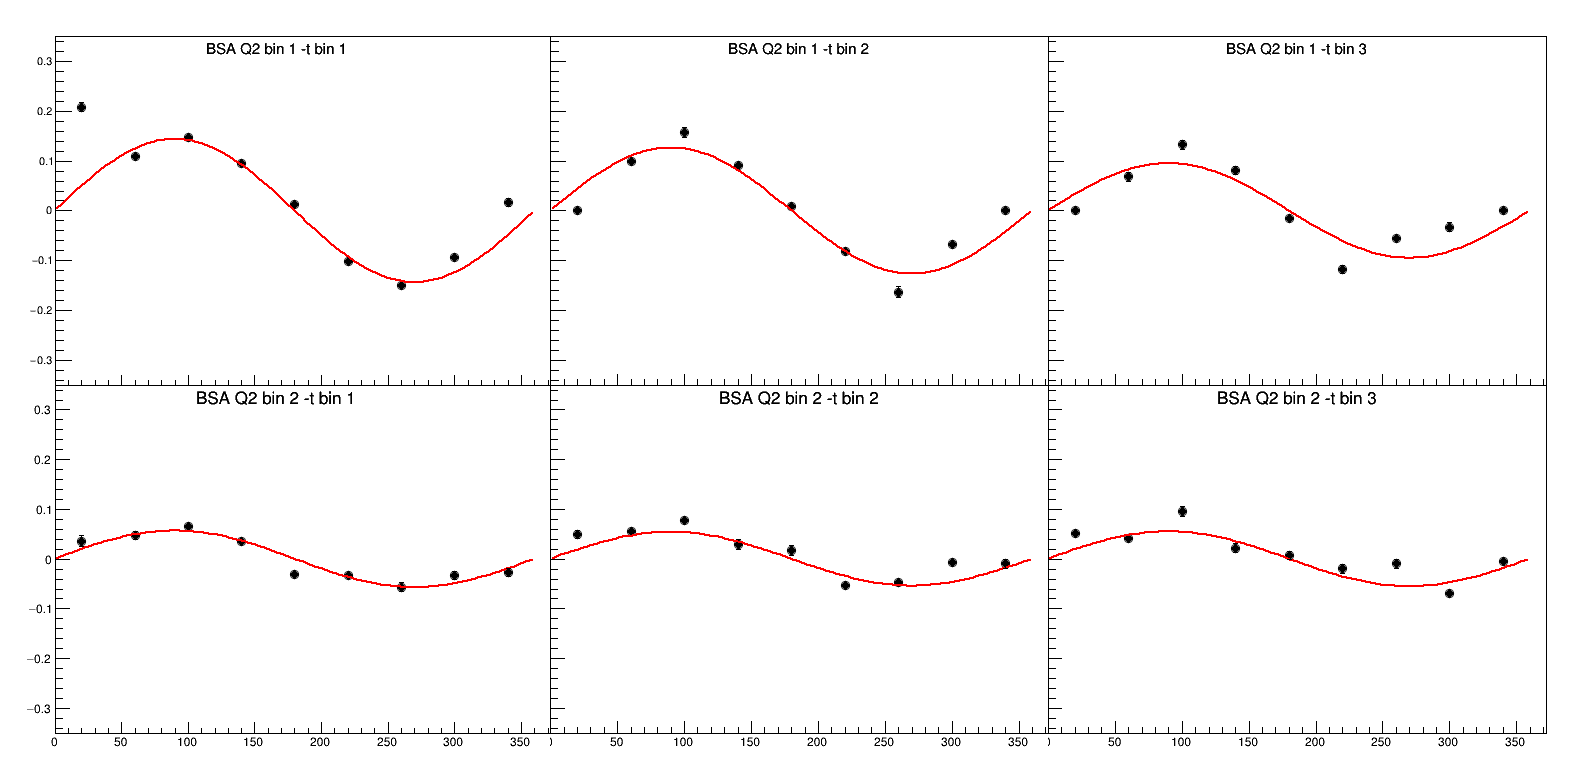

In [4]:
tbinSize = 3

hBSA =[]

for i in range(0,int(splitSize)):
    hBSA.append(ROOT.TGraphErrors())
#print(hBSA)


parsFit = np.zeros(int(splitSize))
parsFitError = np.zeros(int(splitSize))


count = 0
for i in BSA:
    tcount = 0
    for x in i:
        y = trePhi[tcount]
        yerr = eBSA[count][tcount]
        hBSA[count].SetPoint(hBSA[count].GetN(),y,x)
        #print(x,y,count,tCount)
        hBSA[count].SetPointError(hBSA[count].GetN()-1, 0, yerr)
        t1= ROOT.TF1("f1","[0]*sin(x*TMath::DegToRad())",0,360)
        #t1= ROOT.TF1("f1","([0]*sin(x*TMath::DegToRad()))/(1+[1]*cos(x*TMath::DegToRad())+[2]*cos(2*x*TMath::DegToRad()))",0,360)
        hBSA[count].Fit(t1,"QR")
        parsFit[count] = t1.GetParameter(0)
        parsFitError[count] = t1.GetParError(0)
        tcount += 1
    count += 1
        


c4 = ROOT.TCanvas("c1","c1", 1600,800)
c4.Divide(3,2,0,0)
c4.Draw()



count = 1
for i in range(0,6):
    c4.cd(i+1)
    title = "BSA Q2 bin " + str(count) + " -t bin " + str((i%tbinSize) +1)
    hBSA[i].SetTitle(title)
    hBSA[i].GetYaxis().SetRangeUser(-0.35,0.35)
    hBSA[i].SetMarkerStyle(20)
    hBSA[i].Draw("AP")
    if i % tbinSize == (tbinSize-1):
        count +=1
        
   

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


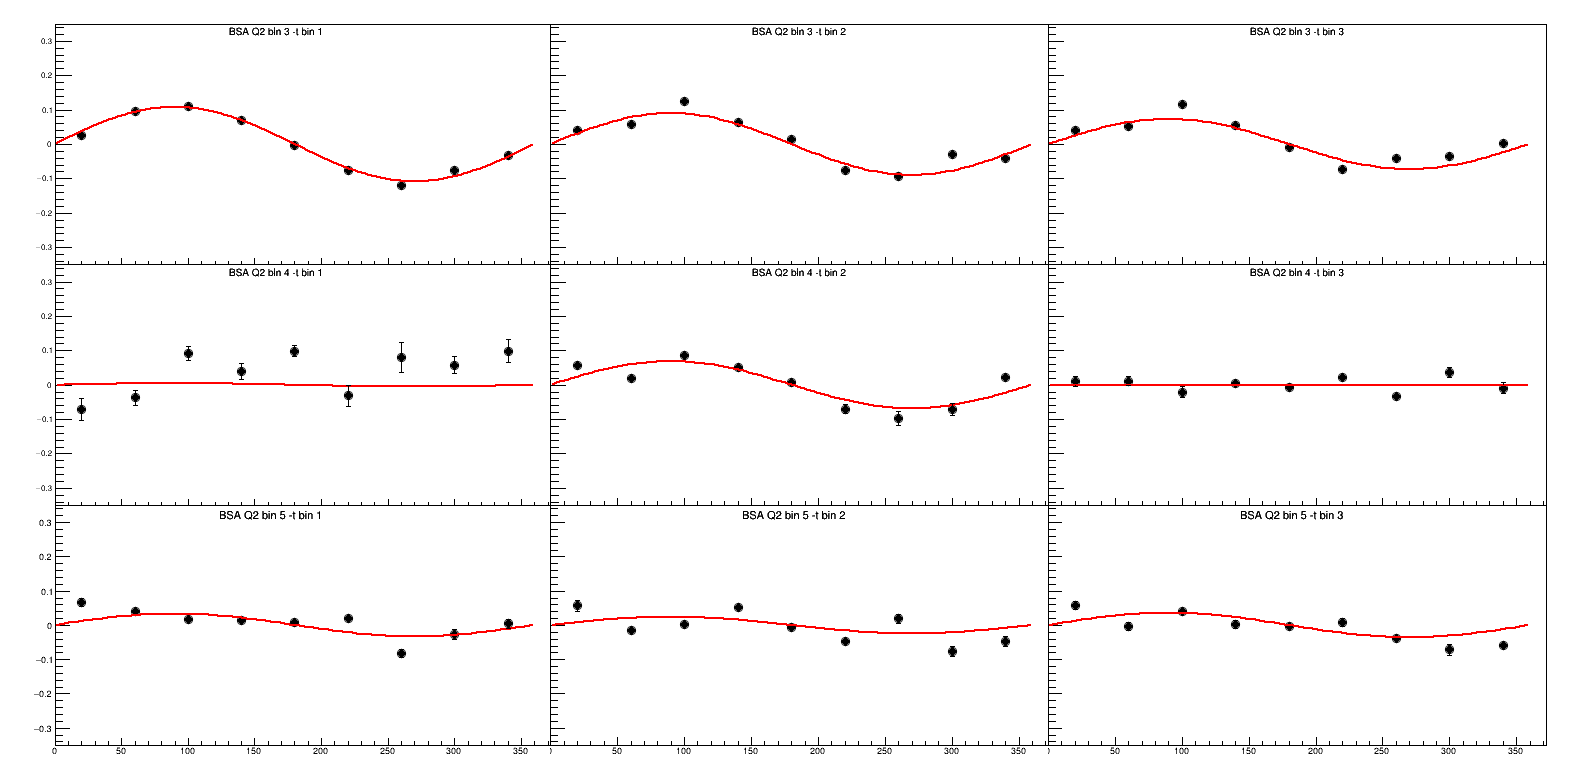

In [5]:
c4 = ROOT.TCanvas("c1","c1", 1600,800)
c4.Divide(3,3,0,0)
c4.Draw()



count = 3
for i in range(6,15):
    c4.cd(i-5)
    title = "BSA Q2 bin " + str(count) + " -t bin " + str((i%tbinSize) +1)
    hBSA[i].SetTitle(title)
    hBSA[i].GetYaxis().SetRangeUser(-0.35,0.35)
    hBSA[i].SetMarkerStyle(20)
    hBSA[i].Draw("AP")
    if i % tbinSize == (tbinSize-1):
        count +=1
    

In [26]:
print((np.split((parsFit),5)))
print((np.split((parsFitError),5)))

[array([0.14407642, 0.12649504, 0.09495111]), array([0.05674143, 0.0539868 , 0.05516462]), array([0.10801034, 0.08976137, 0.07269182]), array([ 0.00486727,  0.06848842, -0.00042125]), array([0.03329681, 0.02436927, 0.03571714])]
[array([0.00355301, 0.00416369, 0.00410797]), array([0.00360168, 0.00353496, 0.0040022 ]), array([0.00339331, 0.00358508, 0.00363409]), array([0.01211991, 0.00582152, 0.00596394]), array([0.00503159, 0.00472717, 0.00542493])]


In [4]:
q2Cuts = ["xb<x1 && Q2>2 && Q2<(y0 + (xb-x0)/(x1-x0)*(y1-y0)) && xb<x01","xb<x1 && Q2>2 && Q2<(y0 + (xb-x0)/(x1-x0)*(y1-y0)) && xb>x01","xb<x1 && Q2>2","xb>x1 && Q2>2 && Q2< (y4 + (xb-x4)/(x5-x4)*(y5-y4))","xb>x1 && Q2>2"]    

tLimits = [np.linspace(0.42,0.9,num=4),np.linspace(0.42,0.9,num=4),np.linspace(0.46,0.9,4),np.linspace(0.62,0.98,4),np.linspace(0.82,1.26,4)] 

tCuts = []
for i in tLimits:
    print("-t > " + str(i[0]) + "  && -t < "+ str(i[1]))
    print("-t > " + str(i[1]) + "  && -t < "+ str(i[2]))
    tCuts.append("mt > " + str(i[0]) + "  && mt < "+ str(i[1]))
    tCuts.append("mt > " + str(i[1]) + "  && mt < "+ str(i[2]))
    tCuts.append("mt > " + str(i[2]) + "  && mt < "+ str(i[3]))
    #tCuts.append((i[0]+i[1])/2)
    #tCuts.append((i[1]+i[2])/2)
    #tCuts.append((i[2]+i[3])/2)
    

tCount = 0
#c1.Print(pdfname+"[")
tVals = []
for k in q2Cuts:
    print(k)
    for j in range(tCount,len(tCuts)):
        print(tCuts[j])
        new = cut2.Filter(k).Filter(tCuts[j])
        tVals.append(new.Mean("mt").GetValue())
        #tVals.append((tCuts[j]))
        tCount += 1
        if tCount % 3 ==0:
            break
            
#tVals = np.array([0.5331873282055748, 0.7732560377737383, 0.5449346436435878, 0.7769909857556524, 0.5677026548254368, 0.7858704317785736, 0.71580461705054, 0.8926693935233038, 0.9329065843445217, 1.1505315462584793])            
tVals = [0.4971369440598597, 0.6569550834832922, 0.8170997962207208, 0.5030596180913797, 0.6596071029685012, 0.8182945024243566, 0.5325006497950542, 0.6784170258792163, 0.8247163870744437, 0.6830860790677337, 0.8015944237187014, 0.9209668879406028, 0.8951726733776048, 1.0407006380693573, 1.186574493472095]
print("tVals =",tVals)

-t > 0.42  && -t < 0.58
-t > 0.58  && -t < 0.74
-t > 0.42  && -t < 0.58
-t > 0.58  && -t < 0.74
-t > 0.46  && -t < 0.6066666666666667
-t > 0.6066666666666667  && -t < 0.7533333333333334
-t > 0.62  && -t < 0.74
-t > 0.74  && -t < 0.86
-t > 0.82  && -t < 0.9666666666666667
-t > 0.9666666666666667  && -t < 1.1133333333333333
xb<x1 && Q2>2 && Q2<(y0 + (xb-x0)/(x1-x0)*(y1-y0)) && xb<x01
mt > 0.42  && mt < 0.58
mt > 0.58  && mt < 0.74
mt > 0.74  && mt < 0.9
xb<x1 && Q2>2 && Q2<(y0 + (xb-x0)/(x1-x0)*(y1-y0)) && xb>x01
mt > 0.42  && mt < 0.58
mt > 0.58  && mt < 0.74
mt > 0.74  && mt < 0.9
xb<x1 && Q2>2
mt > 0.46  && mt < 0.6066666666666667
mt > 0.6066666666666667  && mt < 0.7533333333333334
mt > 0.7533333333333334  && mt < 0.9
xb>x1 && Q2>2 && Q2< (y4 + (xb-x4)/(x5-x4)*(y5-y4))
mt > 0.62  && mt < 0.74
mt > 0.74  && mt < 0.86
mt > 0.86  && mt < 0.98
xb>x1 && Q2>2
mt > 0.82  && mt < 0.9666666666666667
mt > 0.9666666666666667  && mt < 1.1133333333333333
mt > 1.1133333333333333  && mt < 1.26
tVals

In [8]:
tVals = (np.split(np.array(tVals),5))
parsFit = (np.split(np.array(parsFit),5))
parsFitError = (np.split(np.array(parsFitError),5))



# Single Plot

0.14407641855135978 0.5 0
0.12649503580524615 0.6599999999999999 1
0.09495110749492179 0.8200000000000001 2
0.05674142504656181 0.5 0
0.05398679547996752 0.6599999999999999 1
0.0551646213907248 0.8200000000000001 2
0.10801033808280776 0.5333333333333333 0
0.0897613694166192 0.68 1
0.07269182115062893 0.8266666666666667 2
0.004867266496714825 0.6799999999999999 0
0.06848842496316115 0.8 1
-0.000421250872735523 0.9199999999999999 2
0.033296813917636364 0.8933333333333333 0
0.024369273037162076 1.04 1
0.035717144945399716 1.1866666666666665 2


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


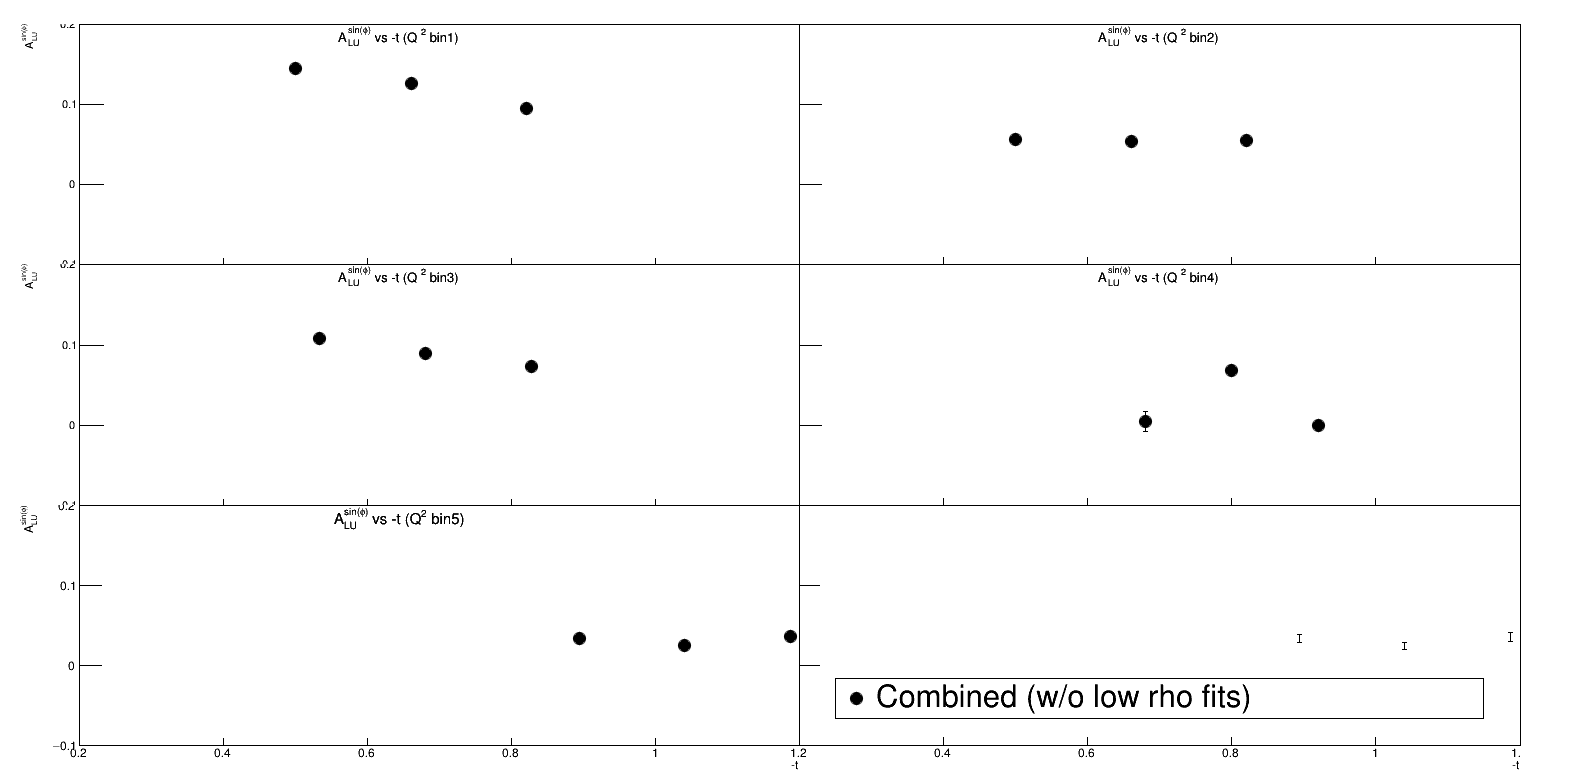

In [9]:
hWSPhi = []
for i in range(0,(6)):
    hWSPhi.append(ROOT.TGraphErrors())
    
    
for i in range(0,5):
    count = 0
    for x in parsFit[i]:
        y =  tVals[i][count]
        yerr = parsFitError[i][count]
        hWSPhi[i].SetPoint(hWSPhi[i].GetN(),y,x)
        print(x,y,count)
        hWSPhi[i].SetPointError(hWSPhi[i].GetN()-1, 0, yerr)
        count = count + 1
        t1= ROOT.TF1("f1","pol2(0)",0,360)
        t1.SetParameter(0,1e5)
        #hWSPhi.Fit(t1,"QR")
c4 = ROOT.TCanvas("c1","c1", 1600,800)
c4.Divide(2,3,0,0)
c4.Draw()

ROOT.gStyle.SetTitleFontSize(0.05)

hWSPhi[5] = hWSPhi[4].Clone()

legend = ROOT.TLegend(0.05, 0.35, 0.95, 0.2)
legend.SetNColumns(4)
legend.AddEntry(hWSPhi[0],"Combined (w/o low rho fits)","P")



for i in range(0,6):
    c4.cd(i+1)
    hWSPhi[i].SetTitle("A^{sin(#phi)}_{LU} vs -t (Q^{2} bin" + str(i+1)+")")

    hWSPhi[i].GetXaxis().SetNdivisions(5)
    hWSPhi[i].GetYaxis().SetNdivisions(5)
    #hWSPhi[i].SetMarkerSize(2)
    
    hWSPhi[i].GetXaxis().SetLimits(0.2,1.2)
    hWSPhi[i].GetXaxis().SetTitle("-t")


    hWSPhi[i].GetXaxis().SetLabelSize(0.05)
    hWSPhi[i].GetXaxis().SetTitleSize(0.05)
    hWSPhi[i].GetXaxis().SetTitleOffset(0.9)

    hWSPhi[i].GetYaxis().SetRangeUser(-0.1,0.2)
    hWSPhi[i].GetYaxis().SetTitle("A^{sin(#phi)}_{LU}")
    hWSPhi[i].GetYaxis().SetLabelSize(0.05)
    hWSPhi[i].GetYaxis().SetTitleSize(0.05)
    hWSPhi[i].GetYaxis().SetTitleOffset(0.8)

    
    hWSPhi[i].SetMarkerStyle(8)
    hWSPhi[i].SetMarkerSize(1.5)
    hWSPhi[i].Draw("AP")


c4.cd(6)
hWSPhi[5].Draw("AF")
hWSPhi[i].SetTitle()
legend.Draw()

# Comparing Inbending and Outbending

In [35]:
# For 2 t bins
parsFit_in_old = np.array([([0.16932886, 0.17636051]), ([0.09134334, 0.06665557]), ([0.1175253 , 0.08670904]), ([0.02012316, 0.02722818]), ([0.02343987, 0.03874902])])
parsFitError_in_old = np.array([([0.00692523, 0.00922742]), ([0.00702514, 0.00995482]), ([0.00602409, 0.00808087]), ([0.01643448, 0.01690483]), ([0.01405967, 0.01382537])])

parsFit_in = np.array([([0.15739646, 0.14116234]), ([0.0693588 , 0.05258058]), ([0.10448816, 0.08997536]), ([0.0222412 , 0.03419081]), ([0.02949821, 0.04722879])])
parsFitError_in = np.array([([0.00488228, 0.0067324 ]), ([0.00473803, 0.0051941 ]), ([0.00437362, 0.00446743]), ([0.00857342, 0.01052098]), ([0.0067132 , 0.00720029])])

parsFit_out_old = np.array([([0.14462886, 0.11256445]), ([0.05693342, 0.06179065]), ([0.09602048, 0.07906778]), ([0.0610269 , 0.02950573]), ([0.02432256, 0.02982355])])
parsFitError_out_old = np.array([([0.004633  , 0.00517549]), ([0.00429916, 0.00583184]), ([0.00426534, 0.00486621]), ([0.00799977, 0.0091417 ]), ([0.00756498, 0.00667656])])

parsFit_out = np.array([([0.1496181 , 0.11495915]), ([0.05720281, 0.06154611]), ([0.09864877, 0.0857504 ]), ([0.03904092, 0.02133598]), ([0.03277127, 0.02526724])])
parsFitError_out = np.array([([0.00463093, 0.00538513]), ([0.00420477, 0.00442264]), ([0.00390467, 0.00410019]), ([0.01000919, 0.00805438]), ([0.00716077, 0.00684737])])

parsFit_old = np.array([([0.1529608, 0.1338005]), ([0.06465386, 0.0561533 ]), ([0.10487811, 0.09384873]), ([0.01665346, 0.0187583 ]), ([0.03011657, 0.03921479])])
parsFitError_old = np.array([([0.0058749 , 0.00993695]), ([0.00637197, 0.00784019]), ([0.00430341, 0.00590573]), ([0.02297526, 0.01723678]), ([0.01351599, 0.0145653 ])])

In [10]:
# for 3 t bins

parsFit_in = np.array([([0.1581687 , 0.14263089, 0.12250647]), ([0.07125155, 0.05695419, 0.05614746]), ([0.1089503 , 0.09474528, 0.0832218 ]), ([0.00891071, 0.03989125, 0.00383208]), ([0.04729091, 0.02697197, 0.03931562])])
parsFitError_in = np.array([([0.00469122, 0.00572333, 0.00572567]), ([0.00352602, 0.00404928, 0.00512017]), ([0.00412288, 0.00429362, 0.00468008]), ([0.01116181, 0.00705985, 0.00669107]), ([0.00616316, 0.00763364, 0.00695237])])



parsFit_out = np.array([([0.12862914, 0.1453417 , 0.09746043]), ([0.06631127, 0.05952729, 0.04485846]), ([0.1005107 , 0.08884291, 0.06299765]), ([ 0.11307719,  0.08775155, -0.00713608]), ([0.02939836, 0.04773922, 0.01757291])])
parsFitError_out = np.array([([0.00412383, 0.00493137, 0.00602755]), ([0.00428945, 0.00425884, 0.00524079]), ([0.00396144, 0.00418021, 0.00425602]), ([0.01383819, 0.00961939, 0.00736026]), ([0.00593612, 0.00673523, 0.00706495])])

[array([0.5 , 0.66, 0.82]), array([0.5 , 0.66, 0.82]), array([0.53333333, 0.68      , 0.82666667]), array([0.68, 0.8 , 0.92]), array([0.89333333, 1.04      , 1.18666667])] [array([0.14407642, 0.12649504, 0.09495111]), array([0.05674143, 0.0539868 , 0.05516462]), array([0.10801034, 0.08976137, 0.07269182]), array([ 0.00486727,  0.06848842, -0.00042125]), array([0.03329681, 0.02436927, 0.03571714])] [array([0.00355301, 0.00416369, 0.00410797]), array([0.00360168, 0.00353496, 0.0040022 ]), array([0.00339331, 0.00358508, 0.00363409]), array([0.01211991, 0.00582152, 0.00596394]), array([0.00503159, 0.00472717, 0.00542493])]
0.14407641855135978 0.5 0
0.12649503580524615 0.6599999999999999 1
0.09495110749492179 0.8200000000000001 2
0.05674142504656181 0.5 0
0.05398679547996752 0.6599999999999999 1
0.0551646213907248 0.8200000000000001 2
0.10801033808280776 0.5333333333333333 0
0.0897613694166192 0.68 1
0.07269182115062893 0.8266666666666667 2
0.004867266496714825 0.6799999999999999 0
0.068488

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


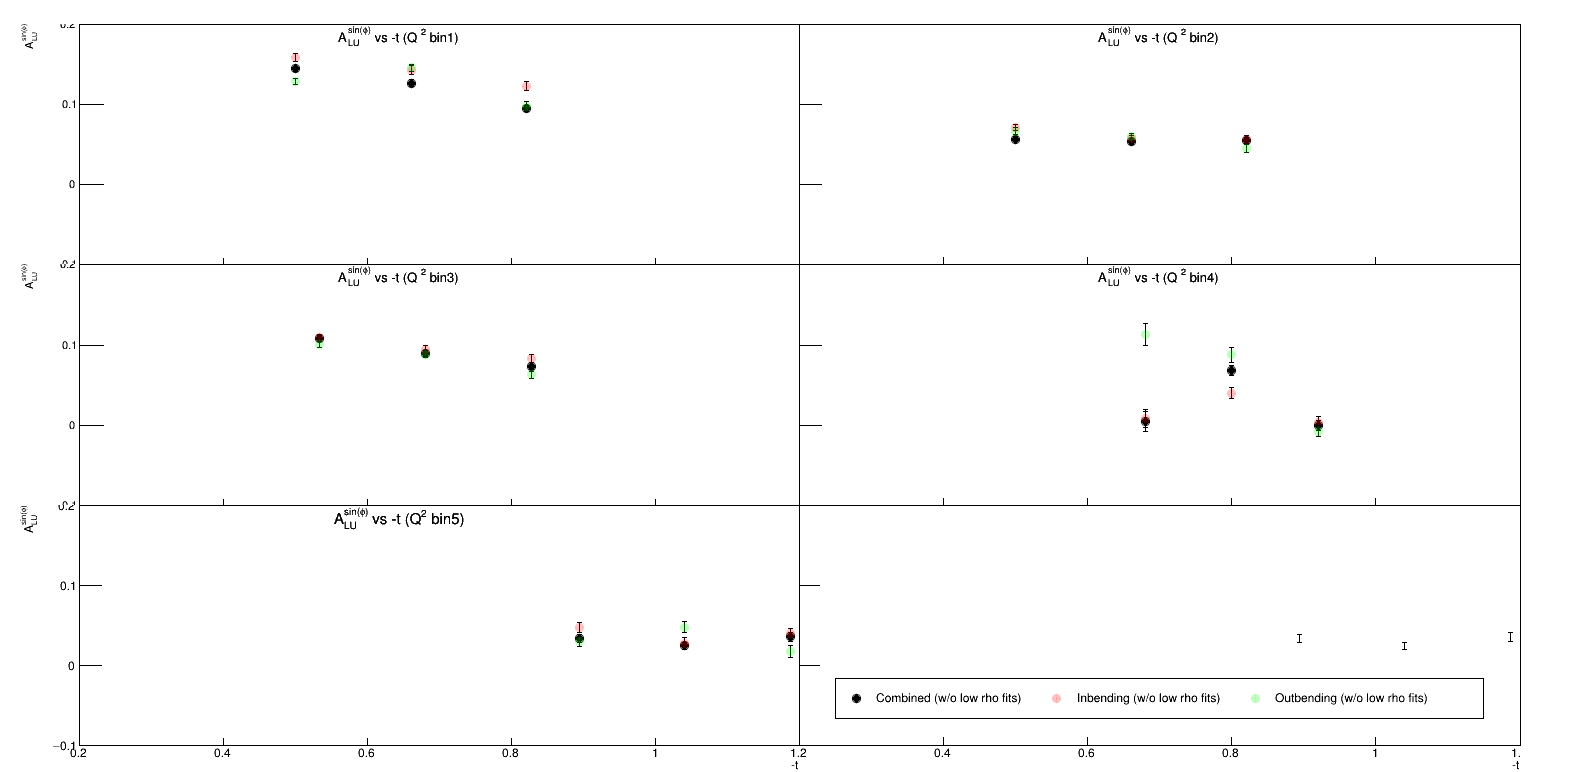

In [11]:

hWSPhi = []
for i in range(0,(6)):
    hWSPhi.append(ROOT.TGraphErrors())
    
hWSPhi_in = []
for i in range(0,(6)):
    hWSPhi_in.append(ROOT.TGraphErrors())
hWSPhi_out = []
for i in range(0,(6)):
    hWSPhi_out.append(ROOT.TGraphErrors())
    
#hWSPhi_old = []
#for i in range(0,(6)):
#    hWSPhi_old.append(ROOT.TGraphErrors())



print(tVals,parsFit,parsFitError)



for i in range(0,5):
    count = 0
    for x in parsFit[i]:
        y =  tVals[i][count]
        yerr = parsFitError[i][count]
        hWSPhi[i].SetPoint(hWSPhi[i].GetN(),y,x)
        print(x,y,count)
        hWSPhi[i].SetPointError(hWSPhi[i].GetN()-1, 0, yerr)
        count = count + 1
        t1= ROOT.TF1("f1","pol2(0)",0,360)
        t1.SetParameter(0,1e5)
        #hWSPhi.Fit(t1,"QR")

for i in range(0,5):
    count = 0
    for x in parsFit_in[i]:
        y =  tVals[i][count]
        yerr = parsFitError_in[i][count]
        hWSPhi_in[i].SetPoint(hWSPhi_in[i].GetN(),y,x)
        print(x,y,count)
        hWSPhi_in[i].SetPointError(hWSPhi_in[i].GetN()-1, 0, yerr)
        count = count + 1
        t1= ROOT.TF1("f1","pol2(0)",0,360)
        t1.SetParameter(0,1e5)
        #hWSPhi.Fit(t1,"QR")
        
for i in range(0,5):
    count = 0
    for x in parsFit_out[i]:
        y =  tVals[i][count]
        yerr = parsFitError_out[i][count]
        hWSPhi_out[i].SetPoint(hWSPhi_out[i].GetN(),y,x)
        print(x,y,count)
        hWSPhi_out[i].SetPointError(hWSPhi_out[i].GetN()-1, 0, yerr)
        count = count + 1
        t1= ROOT.TF1("f1","pol2(0)",0,360)
        t1.SetParameter(0,1e5)
        #hWSPhi.Fit(t1,"QR")
        
#for i in range(0,5):
#    count = 0
#    for x in parsFit_old[i]:
#        y =  tVals[i][count]
#        yerr = parsFitError_old[i][count]
#        hWSPhi_old[i].SetPoint(hWSPhi_old[i].GetN(),y,x)
#        print(x,y,count)
#        hWSPhi_old[i].SetPointError(hWSPhi_old[i].GetN()-1, 0, yerr)
#        count = count + 1
#        t1= ROOT.TF1("f1","pol2(0)",0,360)
#        t1.SetParameter(0,1e5)
        #hWSPhi.Fit(t1,"QR")




c4 = ROOT.TCanvas("c1","c1", 1600,800)
c4.Divide(2,3,0,0)
c4.Draw()

ROOT.gStyle.SetTitleFontSize(0.05)

hWSPhi[5] = hWSPhi[4].Clone()

legend = ROOT.TLegend(0.05, 0.35, 0.95, 0.2)
legend.SetNColumns(4)
legend.AddEntry(hWSPhi[0],"Combined (w/o low rho fits)","P")
legend.AddEntry(hWSPhi_in[0],"Inbending (w/o low rho fits)","P")
legend.AddEntry( hWSPhi_out[0],"Outbending (w/o low rho fits)","P")
#legend.AddEntry( hWSPhi_old[0],"Combined (with low rho fits)","P")


for i in range(0,6):
    c4.cd(i+1)
    hWSPhi[i].SetTitle("A^{sin(#phi)}_{LU} vs -t (Q^{2} bin" + str(i+1)+")")

    hWSPhi[i].GetXaxis().SetNdivisions(5)
    hWSPhi[i].GetYaxis().SetNdivisions(5)
    #hWSPhi[i].SetMarkerSize(2)
    
    hWSPhi[i].GetXaxis().SetLimits(0.2,1.2)
    hWSPhi[i].GetXaxis().SetTitle("-t")


    hWSPhi[i].GetXaxis().SetLabelSize(0.05)
    hWSPhi[i].GetXaxis().SetTitleSize(0.05)
    hWSPhi[i].GetXaxis().SetTitleOffset(0.9)

    hWSPhi[i].GetYaxis().SetRangeUser(-0.1,0.2)
    hWSPhi[i].GetYaxis().SetTitle("A^{sin(#phi)}_{LU}")
    hWSPhi[i].GetYaxis().SetLabelSize(0.05)
    hWSPhi[i].GetYaxis().SetTitleSize(0.05)
    hWSPhi[i].GetYaxis().SetTitleOffset(0.8)

    
    hWSPhi[i].SetMarkerStyle(8)
    hWSPhi[i].Draw("AP")
    
    hWSPhi_in[i].SetMarkerStyle(8)
    hWSPhi_in[i].SetMarkerColorAlpha(2,0.5)
    #hWSPhi_in[i].SetMarkerColor(2)
    hWSPhi_in[i].Draw("P")
    
    hWSPhi_out[i].SetMarkerStyle(8)
    hWSPhi_out[i].SetMarkerColorAlpha(3,0.5)
    #hWSPhi_out[i].SetMarkerColor(3)
    hWSPhi_out[i].Draw("P")
    
    #hWSPhi_old[i].SetMarkerStyle(4)
    #hWSPhi_old[i].SetMarkerColor(4)
    #hWSPhi_old[i].Draw("P")

c4.cd(6)
hWSPhi[5].Draw("AF")
hWSPhi[i].SetTitle()
legend.Draw()